## Final Project Submission

Please fill out:
* Student name: Levi Raichik
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:


# Table of Contents

- [Import Libraries](#Import-Libraries)
- [Functions](#Functions)
- [Load in Dataset](#Load-in-Dataset)
- [Checkout the data](#Checkout-the-data)
- [Balancing out the dataset](#Balancing-out-the-dataset)
    - [Using SMOTE to balance out the dataset](#Using-SMOTE-to-balance-out-the-dataset)  
- [Going into Random forests more to see how it can best be optimized](#Going-into-Random-forests-more-to-see-how-it-can-best-be-optimized)
    - [Trying with balanced bagging](#Trying-with-balanced-bagging)
    - [Regular bagging with the smoted data](#Regular-bagging-with-the-smoted-data)
    - [Cross val with smoted data](#Cross-val-with-smoted-data)
- [Checking feature importance](#Checking-feature-importance)
- [XgBoost](#XgBoost)
- [Looking further into feature importance](#Looking-further-into-feature-importance)
- [Final Model](#Final-Model)
- [Recommendations](#Recommendations)
- [Further Work](#Further-Work)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn import svm

[Return to contents](#Table-of-Contents)

## Functions

In [2]:
def cm(y_real, y_pred, t='test'):
    cf = confusion_matrix(y_real, y_pred)
    print(f"Confusion Matrix {t}: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf/(np.sum(cf)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [3]:
def cmcb(y_real, y_pred, t='test'):
    cbarray = np.array([0,-500,-1440,940])
    cf = confusion_matrix(y_real, y_pred)
    print(f"Confusion Matrix {t}: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf/(np.sum(cf)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [4]:
def cost_benefit(y_true, y_pred, promo = 500, income24m = 60*24):
    m = confusion_matrix(y_true, y_pred)
    FP = m[0][1]*promo
    FN = m[1][0]*income24m
    TP = m[1][1]*(income24m-promo)
    return TP - (FP+FN)

## Load in Dataset

In [5]:
df = pd.read_csv('churn.csv')
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,2845,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


[Return to contents](#Table-of-Contents)

## Checkout the data

General Stats

In [6]:
df.describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,25.99840,100.25860,436.911400,2499.500000,0.094600,0.264600,7.755200,180.288900,100.029400,30.649668,...,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400,0.141400
std,14.80348,39.69456,42.209182,1443.520003,0.292691,0.441164,13.546393,53.894699,19.831197,9.162069,...,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363,0.348469
min,0.00000,1.00000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.00000,73.00000,408.000000,1249.750000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,...,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.00000,100.00000,415.000000,2499.500000,0.000000,0.000000,0.000000,180.100000,100.000000,30.620000,...,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,39.00000,127.00000,415.000000,3749.250000,0.000000,1.000000,17.000000,216.200000,113.000000,36.750000,...,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,50.00000,243.00000,510.000000,4999.000000,1.000000,1.000000,52.000000,351.500000,165.000000,59.760000,...,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [7]:
df.loc[df['class'] == 1].describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,...,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.0
mean,26.251768,102.332390,437.971711,2543.499293,0.281471,0.144272,4.496464,207.870580,100.817539,35.338416,...,99.884017,17.999562,206.078218,99.575672,9.273607,10.692362,4.151344,2.887426,2.254597,1.0
std,14.228766,39.396993,42.848131,1425.252780,0.450035,0.351614,11.297719,68.576475,20.757110,11.658195,...,19.618258,4.383293,49.685763,19.968555,2.235902,2.793187,2.550011,0.754057,1.815956,0.0
min,0.000000,1.000000,408.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,48.000000,6.030000,47.400000,42.000000,2.130000,0.000000,0.000000,0.000000,0.000000,1.0
25%,15.000000,76.000000,411.500000,1310.500000,0.000000,0.000000,0.000000,153.500000,88.000000,26.095000,...,86.500000,14.945000,171.750000,85.000000,7.730000,8.800000,2.000000,2.380000,1.000000,1.0
50%,26.000000,102.000000,415.000000,2576.000000,0.000000,0.000000,0.000000,215.900000,101.000000,36.700000,...,99.000000,17.940000,206.300000,100.000000,9.280000,10.600000,4.000000,2.860000,2.000000,1.0
75%,38.000000,126.500000,510.000000,3770.000000,1.000000,0.000000,0.000000,266.450000,115.000000,45.295000,...,113.500000,21.190000,240.850000,114.000000,10.840000,12.800000,5.000000,3.460000,4.000000,1.0
max,50.000000,225.000000,510.000000,4985.000000,1.000000,1.000000,48.000000,351.500000,165.000000,59.760000,...,168.000000,30.910000,381.600000,158.000000,17.170000,20.000000,20.000000,5.400000,9.000000,1.0


In [8]:
df.loc[df['class'] == 0].describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,...,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.0
mean,25.956674,99.917074,436.736781,2492.253902,0.063825,0.284416,8.291870,175.746564,99.899604,29.877494,...,100.241556,16.898654,199.455113,99.975775,8.975593,10.190869,4.481947,2.752055,1.457722,0.0
std,14.897193,39.737531,42.105520,1446.542156,0.244469,0.451189,13.809408,49.634575,19.674019,8.437810,...,19.862391,4.262900,50.609570,19.958820,2.277438,2.749994,2.438233,0.742443,1.164236,0.0
min,0.000000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,13.000000,73.000000,408.000000,1240.000000,0.000000,0.000000,0.000000,142.900000,87.000000,24.290000,...,87.000000,13.980000,165.900000,87.000000,7.470000,8.500000,3.000000,2.300000,1.000000,0.0
50%,26.000000,99.000000,415.000000,2485.000000,0.000000,0.000000,0.000000,178.000000,100.000000,30.260000,...,101.000000,16.960000,199.000000,100.000000,8.960000,10.300000,4.000000,2.780000,1.000000,0.0
75%,39.000000,127.000000,415.000000,3746.000000,0.000000,1.000000,20.000000,210.700000,113.000000,35.820000,...,114.000000,19.750000,233.400000,113.000000,10.500000,12.000000,6.000000,3.240000,2.000000,0.0
max,50.000000,243.000000,510.000000,4999.000000,1.000000,1.000000,52.000000,315.600000,163.000000,53.650000,...,170.000000,30.750000,395.000000,175.000000,17.770000,19.700000,19.000000,5.320000,8.000000,0.0


Seeing what the columns are and if there are any null values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null int64
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null int64
international_plan               5000 non-null int64
voice_mail_plan                  5000 non-null int64
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes               

Checking the general distributions of the features

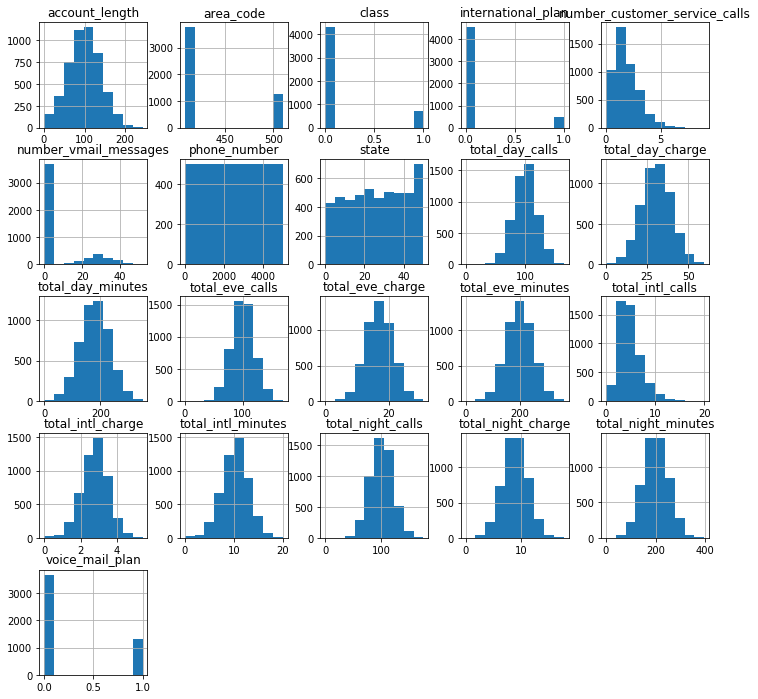

In [10]:
df.hist(figsize=(12,12));

Notice that we have very few cancellation customers. 

In [11]:
df['class'].value_counts()

0    4293
1     707
Name: class, dtype: int64

Checking out a correlation matrix of the data

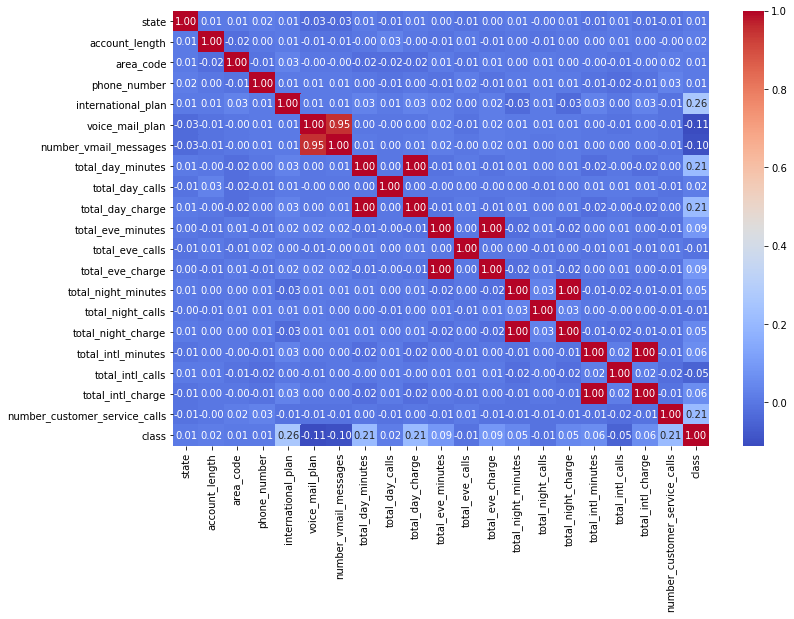

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(round(df.corr(), 2), cmap='coolwarm', annot=True, fmt='.2f');

Notice how minutes and charges are very correlated

Checkout how many unique values there are for each feature

In [13]:
for col in df.columns:
    print(f'\n{col}')
    print(len(df[col].unique()))


state
51

account_length
218

area_code
3

phone_number
5000

international_plan
2

voice_mail_plan
2

number_vmail_messages
48

total_day_minutes
1961

total_day_calls
123

total_day_charge
1961

total_eve_minutes
1879

total_eve_calls
126

total_eve_charge
1659

total_night_minutes
1853

total_night_calls
131

total_night_charge
1028

total_intl_minutes
170

total_intl_calls
21

total_intl_charge
170

number_customer_service_calls
10

class
2


I will drop phone numbers as each one is different anyway

In [14]:
df = df.drop(['phone_number'], axis=1)
df.head(1)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0


[Return to contents](#Table-of-Contents)

## Balancing out the dataset

First splitting the data

In [15]:
X = df.drop(['class'], axis=1)
y = df['class']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

Checking to make sure there are enough cancellation customers in the train and test split

In [17]:
y_test.value_counts()

0    861
1    139
Name: class, dtype: int64

In [18]:
y_train.value_counts()

0    3432
1     568
Name: class, dtype: int64

Seems to be fine

### Using SMOTE to balance out the dataset

In [19]:
sm = SMOTE(n_jobs=-1)

In [20]:
X_train_smoted, y_train_smoted = sm.fit_sample(X_train, y_train)

Try it with a baseline random forest

In [21]:
rf = RandomForestClassifier()

In [22]:
rf.fit(X_train_smoted, y_train_smoted)

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
train_pred = rf.predict(X_train)
train_pred_smoted = rf.predict(X_train_smoted)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


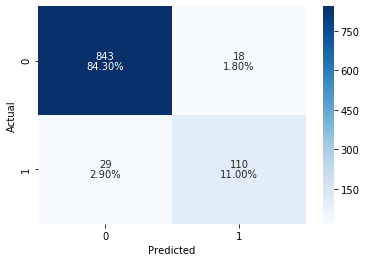

In [24]:
cm(y_test, test_pred)

Confusion Matrix train: 


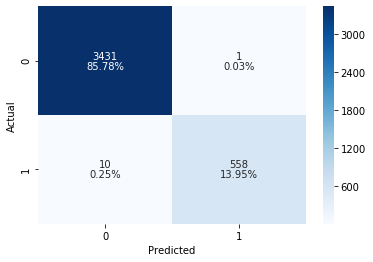

In [25]:
cm(y_train, train_pred, t='train')

Confusion Matrix train_smoted: 


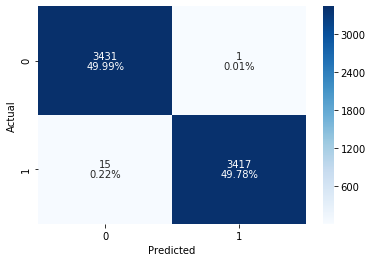

In [26]:
cm(y_train_smoted, train_pred_smoted, t='train_smoted')

Just playing with the probs a bit to see what I can change

In [27]:
test_predprobs = rf.predict_proba(X_test)

In [28]:
probs = []
for x in test_predprobs:
    if x[0] >= .65:
        probs.append(0)
    else:
        probs.append(1)   
        

Confusion Matrix test: 


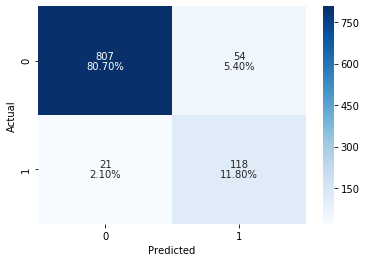

In [29]:
cm(y_test, probs, t='test')

In [30]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       861
           1       0.86      0.79      0.82       139

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.91      0.89      0.90      1000
weighted avg       0.95      0.95      0.95      1000



[Return to contents](#Table-of-Contents)

## Going into Random forests more to see how it can best be optimized

GridsearchCV

In [31]:
clf = RandomForestClassifier()
param_grid = {
    "n_estimators": [10,50,100],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_leaf": [10, 11, 12, 15],
    "min_impurity_decrease": [.0001, .001, .01]
}
gs_tree = GridSearchCV(clf, param_grid, cv=5, scoring='recall',  n_jobs=-1, verbose=2)
gs_tree.fit(X_train_smoted, y_train_smoted)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_leaf': [10, 11, 12, 15], 'min_impurity_decrease': [0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

Putting the full Gridsearch results into a dataframe

In [32]:
rf_gs = pd.DataFrame(gs_tree.cv_results_)
rf_gs.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.050200,0.003763,0.003801,0.000404,gini,1,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.694347,0.048967,272,0.836794,0.635701,0.690095,0.634377,0.673707,0.694135,0.074526
1,0.215397,0.008821,0.012000,0.002605,gini,1,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.776807,0.114656,197,0.692896,0.790893,0.803350,0.829934,0.813547,0.786124,0.048337
2,0.418393,0.011521,0.020201,0.000748,gini,1,0.0001,10,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.751166,0.066298,217,0.797814,0.730055,0.684632,0.830299,0.725419,0.753644,0.052807
3,0.042997,0.002194,0.003601,0.000491,gini,1,0.0001,11,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.720571,0.117370,258,0.854645,0.651730,0.765113,0.788055,0.472323,0.706373,0.134069
4,0.210796,0.008183,0.011200,0.000400,gini,1,0.0001,11,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.739510,0.027719,233,0.862659,0.685246,0.682811,0.691916,0.742899,0.733106,0.068406


Checking to see if best params test and train scores are close so there is not overfitting happening

In [33]:
rf_gs.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
260,2.230396,0.044008,0.036801,0.005191,entropy,10,0.0001,12,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.918124,0.046999,1,0.951913,0.925319,0.922068,0.928259,0.931173,0.931746,0.010527
269,2.200997,0.031170,0.033200,0.001468,entropy,10,0.001,11,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.916958,0.048901,2,0.948998,0.927869,0.926438,0.926803,0.934086,0.932839,0.008541
271,1.098997,0.019930,0.018801,0.002135,entropy,10,0.001,12,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.915501,0.045862,3,0.948998,0.930419,0.920248,0.931537,0.927895,0.931819,0.009449
259,1.128000,0.014000,0.018001,0.001096,entropy,10,0.0001,12,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.915501,0.052404,3,0.947541,0.929690,0.926803,0.921704,0.934086,0.931965,0.008766
254,2.421796,0.101159,0.034001,0.001265,entropy,10,0.0001,10,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.915210,0.047230,5,0.950091,0.927869,0.922068,0.928259,0.935543,0.932766,0.009660


In [34]:
gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'min_samples_leaf': 12,
 'n_estimators': 100}

Making the model

rf2 = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=10, min_impurity_decrease=.0001, min_samples_leaf=15)
rf2.fit(X_train_smoted, y_train_smoted)

Checking the results

In [36]:
train_pred2 = rf2.predict(X_train)
train_pred_smoted2 = rf2.predict(X_train_smoted)
test_pred2 = rf2.predict(X_test)

Confusion Matrix test: 


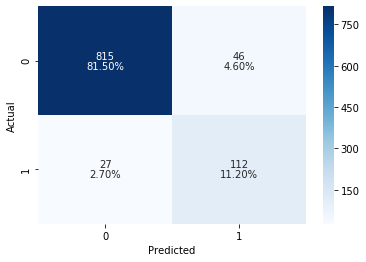

In [37]:
cm(y_test, test_pred2)

Check the FN to see more about them

In [38]:
indices = []
for i, true, pred in zip(y_test.index, y_test.values, test_pred2):
    if pred == 0 and true == 1:
        indices.append(i)

In [39]:
print(indices)

[2468, 2377, 4257, 84, 3601, 2819, 2575, 4624, 2357, 626, 4996, 3382, 2672, 354, 2405, 4112, 1965, 4324, 1115, 2934, 3409, 1746, 1718, 4210, 2925, 3148, 944]


(array([3., 7., 2., 0., 6., 0., 1., 2., 1., 5.]),
 array([0.02385461, 0.07121886, 0.11858311, 0.16594736, 0.21331161,
        0.26067586, 0.3080401 , 0.35540435, 0.4027686 , 0.45013285,
        0.4974971 ]),
 <a list of 10 Patch objects>)

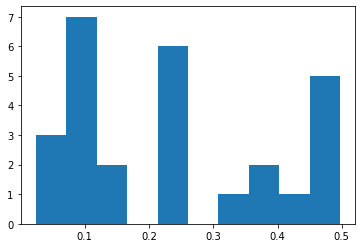

In [40]:
plt.hist(rf2.predict_proba(X.loc[indices])[:, 1])

Change probs

In [41]:
fn_probs = rf2.predict_proba(X.loc[indices])[:, 1]

In [42]:
print(sorted(fn_probs))

[0.02385461194705939, 0.04798591650017654, 0.06449017263713186, 0.0755979607550958, 0.07588939950762355, 0.08003109339682343, 0.08012035493170469, 0.08253716597066045, 0.08365308914138576, 0.11364855691448653, 0.12486138329789638, 0.13614408594467298, 0.21722071843609214, 0.2186469169517895, 0.22668183353331814, 0.22882928813811584, 0.24600985640186784, 0.25679102458693814, 0.3496373484155021, 0.3570733892822799, 0.3782092196930906, 0.4461586664264014, 0.4758094014603299, 0.48701140323091535, 0.4914074830342157, 0.4937854111203963, 0.4974970984809694]


In [43]:
probs = []
for i in rf2.predict_proba(X_test):
    if i[1] >=.42:
        probs.append(1)
    else:
        probs.append(0)

Check results with changed probs

Confusion Matrix test: 


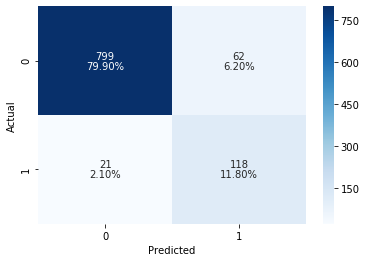

In [44]:
cm(y_test, probs)

Confusion Matrix train: 


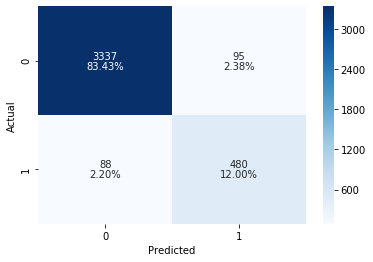

In [45]:
cm(y_train, train_pred2, t='train')

Confusion Matrix train_smoted: 


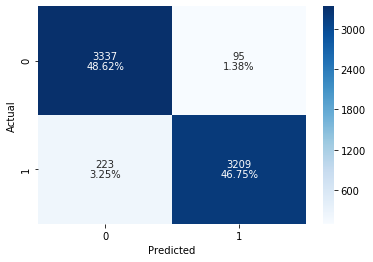

In [46]:
cm(y_train_smoted, train_pred_smoted2, t='train_smoted')

In [47]:
print(classification_report(y_test, test_pred2))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       861
           1       0.71      0.81      0.75       139

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.88      0.86      1000
weighted avg       0.93      0.93      0.93      1000



In [48]:
print(classification_report(y_train, train_pred2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3432
           1       0.83      0.85      0.84       568

   micro avg       0.95      0.95      0.95      4000
   macro avg       0.90      0.91      0.91      4000
weighted avg       0.95      0.95      0.95      4000



In [49]:
print(classification_report(y_test, probs))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       861
           1       0.66      0.85      0.74       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.81      0.89      0.85      1000
weighted avg       0.93      0.92      0.92      1000



[Return to contents](#Table-of-Contents)

### Trying with balanced bagging

To try and get better results

In [50]:
bag = BalancedBaggingClassifier(base_estimator=rf2, verbose=2, n_jobs=-1, n_estimators=50)

In [51]:
bag.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


BalancedBaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
             random_state=None, ratio=None, replacement=False,
             sampling_strategy='auto', verbose=2, warm_start=False)

In [52]:
train_predb = bag.predict(X_train)
test_predb = bag.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Checking the results

Confusion Matrix test: 


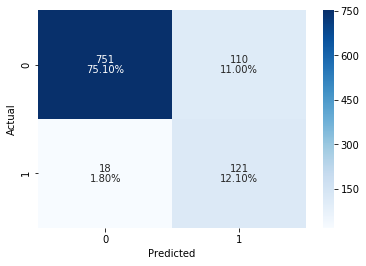

In [53]:
cm(y_test, test_predb)

Confusion Matrix train: 


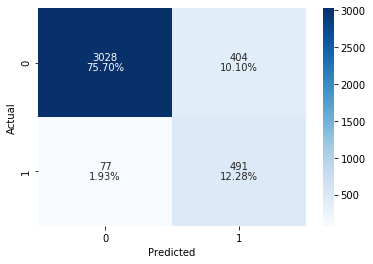

In [54]:
cm(y_train, train_predb, t='train')

Checking FN and changing the probs to test if I can get better results that way

In [55]:
indices3 = []
for i, true, pred in zip(y_test.index, y_test.values, test_predb):
    if pred == 0 and true == 1:
        indices3.append(i)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


(array([2., 3., 2., 2., 0., 2., 2., 2., 1., 2.]),
 array([0.13287396, 0.15697243, 0.1810709 , 0.20516937, 0.22926785,
        0.25336632, 0.27746479, 0.30156327, 0.32566174, 0.34976021,
        0.37385869]),
 <a list of 10 Patch objects>)

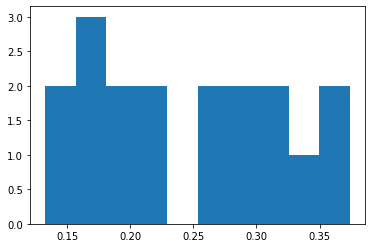

In [56]:
plt.hist(bag.predict_proba(X.loc[indices3])[:, 1])

In [57]:
fn_probs3 = bag.predict_proba(X.loc[indices3])[:, 1]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [58]:
print(sorted(fn_probs3))

[0.13287395532015134, 0.1453526110581816, 0.1635875351680528, 0.1764864742769869, 0.177503242006482, 0.18212702257976462, 0.18766537450636167, 0.21322727527827248, 0.2137269510632074, 0.2606546319954778, 0.2632142039304075, 0.27748022670773387, 0.2918213975037351, 0.3216318665401059, 0.32385952414347635, 0.3448485878089004, 0.3579733643240104, 0.3738586851009095]


In [59]:
probs3 = []
for i in bag.predict_proba(X_test):
    if i[1] >=.32:
        probs3.append(1)
    else:
        probs3.append(0)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Checking results with changed probs

Confusion Matrix test: 


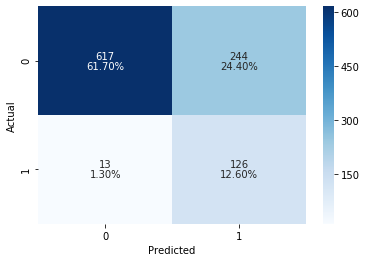

In [60]:
cm(y_test, probs3)

In general there seems to be many more FP with balanced bagging

[Return to contents](#Table-of-Contents)

### Regular bagging with the smoted data

Seeing if this can do better then regular random forests

In [61]:
bagreg = BaggingClassifier(base_estimator=rf2, n_jobs=-1, n_estimators=50)

In [62]:
bagreg.fit(X_train_smoted, y_train_smoted)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [63]:
train_predb = bagreg.predict(X_train)
test_predb = bagreg.predict(X_test)

Checking results and the cost benefit numbers as well

Confusion Matrix test: 


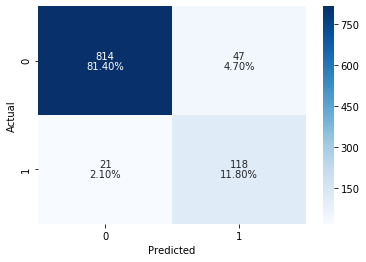

In [64]:
cm(y_test, test_predb)

In [65]:
cost_benefit(y_test, test_predb)

57180

Confusion Matrix train: 


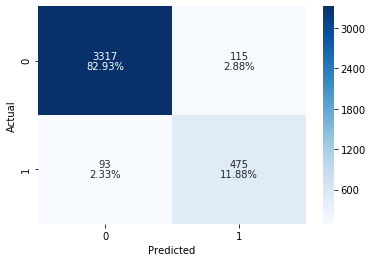

In [66]:
cm(y_train, train_predb, t='train')

In [67]:
print(classification_report(y_test, test_predb))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       861
           1       0.72      0.85      0.78       139

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.85      0.90      0.87      1000
weighted avg       0.94      0.93      0.93      1000



Checking FN results and changing probs to try to better tweak the results

In [68]:
indices3 = []
for i, true, pred in zip(y_test.index, y_test.values, test_predb):
    if pred == 0 and true == 1:
        indices3.append(i)

In [69]:
fn_probs3 = bagreg.predict_proba(X.loc[indices3])[:, 1]

In [70]:
print(sorted(fn_probs3))

[0.04809486680712472, 0.06499193119185673, 0.07281926086353814, 0.08248067100181526, 0.0851896723057631, 0.09338154984744568, 0.10341775361096558, 0.1102083345812642, 0.11293826099451149, 0.11781599071567035, 0.13970245642747833, 0.14618793082016754, 0.14906961532536578, 0.15102865498576581, 0.16572974046971217, 0.238152541780313, 0.2612823544502371, 0.2783951359543238, 0.4822443544794362, 0.4838397340211445, 0.491587900432737]


In [71]:
probs3 = []
for i in bagreg.predict_proba(X_test):
    if i[1] >=.47:
        probs3.append(1)
    else:
        probs3.append(0)

Checking results and cost benefit 

Confusion Matrix test: 


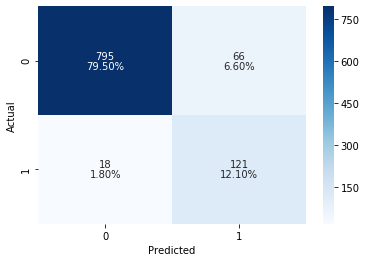

In [72]:
cm(y_test, probs3)

In [73]:
cost_benefit(y_test, probs3)

54820

In [74]:
print(classification_report(y_test, probs3))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       861
           1       0.65      0.87      0.74       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.81      0.90      0.85      1000
weighted avg       0.93      0.92      0.92      1000



Much better results

[Return to contents](#Table-of-Contents)

### Cross val with smoted data

splitting with stratified kfold so the train and test sizes have simlar amounts of leaving and staying customers

In [75]:
skf = StratifiedKFold(n_splits=5)

In [76]:
for train_index, test_index in skf.split(X, y):
    print(len(train_index), len(test_index))

3999 1001
3999 1001
4000 1000
4001 999
4001 999


Get each split from the Kfolds

In [77]:
X_trains2 = {}
X_tests2 = {}
y_trains2 = {}
y_tests2 = {}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(i)
    print(train_index)
    X_trains2[i] = X.loc[train_index]
    X_tests2[i] = X.loc[test_index]
    y_trains2[i] = y[train_index]
    y_tests2[i] = y[test_index]

0
[ 988  989  990 ... 4997 4998 4999]
1
[   0    1    2 ... 4997 4998 4999]
2
[   0    1    2 ... 4997 4998 4999]
3
[   0    1    2 ... 4997 4998 4999]
4
[   0    1    2 ... 3998 3999 4000]


Get recall scores and cost/benefit from each split then get the mean for each one


0.7746478873239436
Confusion Matrix test: 


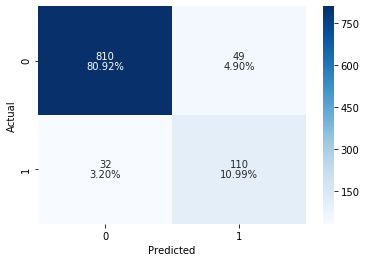

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       859
           1       0.69      0.77      0.73       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.86      0.84      1001
weighted avg       0.92      0.92      0.92      1001


0.8450704225352113
Confusion Matrix test probs: 


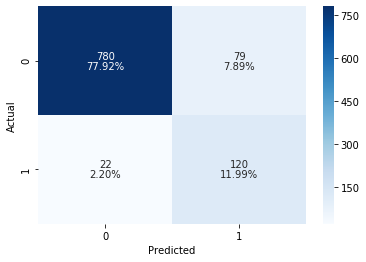

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       859
           1       0.60      0.85      0.70       142

   micro avg       0.90      0.90      0.90      1001
   macro avg       0.79      0.88      0.82      1001
weighted avg       0.92      0.90      0.91      1001


0.823943661971831
Confusion Matrix test: 


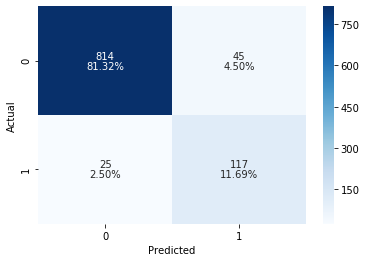

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.72      0.82      0.77       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.85      0.89      0.86      1001
weighted avg       0.94      0.93      0.93      1001


0.8450704225352113
Confusion Matrix test probs: 


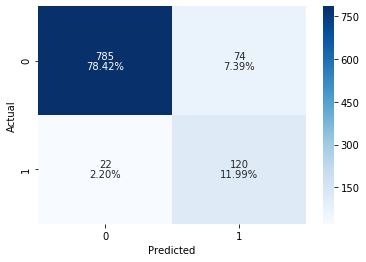

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       859
           1       0.62      0.85      0.71       142

   micro avg       0.90      0.90      0.90      1001
   macro avg       0.80      0.88      0.83      1001
weighted avg       0.92      0.90      0.91      1001


0.7730496453900709
Confusion Matrix test: 


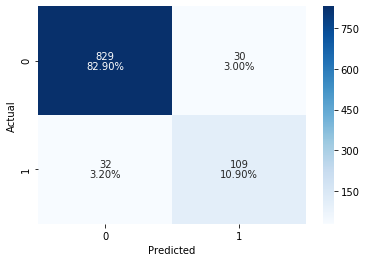

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       859
           1       0.78      0.77      0.78       141

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.94      0.94      0.94      1000


0.8439716312056738
Confusion Matrix test probs: 


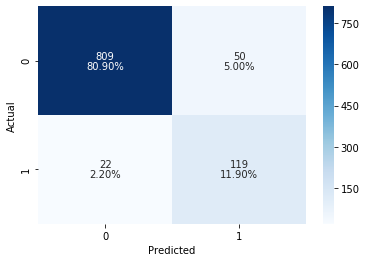

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.84      0.77       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.89      0.86      1000
weighted avg       0.94      0.93      0.93      1000


0.7801418439716312
Confusion Matrix test: 


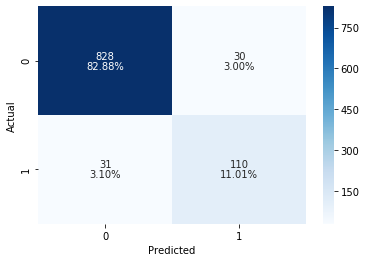

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       858
           1       0.79      0.78      0.78       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.87      0.87      0.87       999
weighted avg       0.94      0.94      0.94       999


0.8226950354609929
Confusion Matrix test probs: 


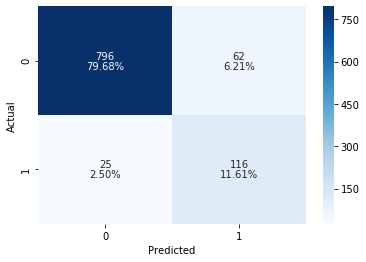

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       858
           1       0.65      0.82      0.73       141

   micro avg       0.91      0.91      0.91       999
   macro avg       0.81      0.88      0.84       999
weighted avg       0.92      0.91      0.92       999


0.8439716312056738
Confusion Matrix test: 


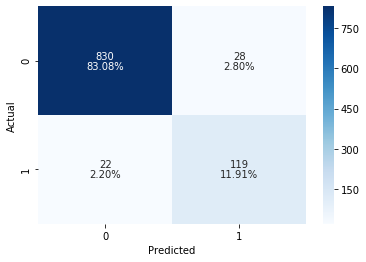

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       858
           1       0.81      0.84      0.83       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.89      0.91      0.90       999
weighted avg       0.95      0.95      0.95       999


0.8723404255319149
Confusion Matrix test probs: 


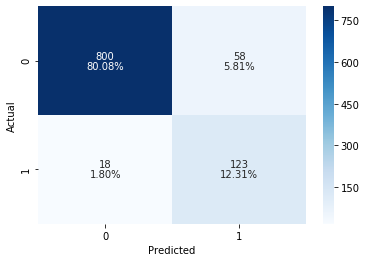

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       858
           1       0.68      0.87      0.76       141

   micro avg       0.92      0.92      0.92       999
   macro avg       0.83      0.90      0.86       999
weighted avg       0.94      0.92      0.93       999

0.8468901466587446 0.7991509339726302 47124.0 0.8645704993902248 0.8458295874538008 48732.0


In [78]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains2[i], y_trains2[i])
    bagreg.fit(smoted_x, smoted_y)
    trainpred = bagreg.predict(X_trains2[i])
    testpred = bagreg.predict(X_tests2[i])
    train += recall_score(y_trains2[i], trainpred)
    test += recall_score(y_tests2[i], testpred)
    probs = []
    for a in bagreg.predict_proba(X_tests2[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in bagreg.predict_proba(X_trains2[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests2[i], testpred)
    probcb += cost_benefit(y_tests2[i], probs)
    testprobs += recall_score(y_tests2[i], probs)
    trainprobs += recall_score(y_trains2[i], probs2
                              )
    scores2.append((i, recall_score(y_trains2[i], trainpred), recall_score(y_tests2[i], testpred), recall_score(y_trains2[i], probs2), recall_score(y_tests2[i], probs)))
    print(f'\n{recall_score(y_tests2[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests2[i], testpred))
    print(f'\n{recall_score(y_tests2[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests2[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

In [79]:
scores2

[(0,
  0.8530973451327434,
  0.7746478873239436,
  0.8690265486725663,
  0.8450704225352113),
 (1,
  0.8460176991150442,
  0.823943661971831,
  0.8654867256637168,
  0.8450704225352113),
 (2,
  0.8498233215547704,
  0.7730496453900709,
  0.8692579505300353,
  0.8439716312056738),
 (3,
  0.8374558303886925,
  0.7801418439716312,
  0.8568904593639576,
  0.8226950354609929),
 (4,
  0.8480565371024735,
  0.8439716312056738,
  0.8621908127208481,
  0.8723404255319149)]

[Return to contents](#Table-of-Contents)

## Checking feature importance

In [80]:
importance = rf2.feature_importances_

In [81]:
importance

array([0.01569479, 0.00912263, 0.02991013, 0.16730389, 0.05810296,
       0.03061684, 0.13605521, 0.00903879, 0.11941256, 0.0405949 ,
       0.00738069, 0.03611248, 0.02077849, 0.00791397, 0.01985282,
       0.02066069, 0.06119469, 0.0133104 , 0.19694307])

Make a df with each column sorted by importance

In [82]:
importdf = pd.DataFrame(importance)
importdf['columns'] = X.columns
importdf.sort_values(by=[0], ascending=False)

,0,columns
18,0.196943,number_customer_service_calls
3,0.167304,international_plan
6,0.136055,total_day_minutes
8,0.119413,total_day_charge
16,0.061195,total_intl_calls
4,0.058103,voice_mail_plan
9,0.040595,total_eve_minutes
11,0.036112,total_eve_charge
5,0.030617,number_vmail_messages
2,0.029910,area_code


Testing out the differences with the training and testing data, Keeping the same split to be able to compare

In [83]:
X_trainim = X_train.drop(['total_night_calls', 'total_eve_calls', 'account_length', 'total_day_calls'], axis=1)
X_testim = X_test.drop(['total_night_calls', 'total_eve_calls', 'account_length', 'total_day_calls'], axis=1)

In [84]:
smoted_xim, smoted_yim = sm.fit_sample(X_trainim, y_train)

searching for best params

In [85]:
clfim = RandomForestClassifier()
param_gridim = {
    "n_estimators": [10,50,100],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_leaf": [10, 11, 12, 15],
    "min_impurity_decrease": [.0001, .001, .01, .1]
}
gs_treeim = GridSearchCV(clfim, param_gridim, cv=5, scoring='recall',  n_jobs=-1, verbose=2)
gs_treeim.fit(smoted_xim, smoted_yim)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 769 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1134 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 1579 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.0min finished
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_leaf': [10, 11, 12, 15], 'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

Putting results in a df to check them

In [86]:
rf_gsim = pd.DataFrame(gs_treeim.cv_results_)
rf_gsim.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.041788,0.002467,0.004000,0.000001,gini,1,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.659674,0.093704,323,0.664117,0.570128,0.737800,0.636926,0.747997,0.671394,0.065990
1,0.221799,0.014959,0.017801,0.008281,gini,1,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.748834,0.076069,235,0.753734,0.795993,0.799709,0.662782,0.751275,0.752698,0.049340
2,0.474988,0.032529,0.027999,0.005019,gini,1,0.0001,10,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.757867,0.058042,227,0.818944,0.754463,0.650036,0.796431,0.801529,0.764281,0.060922
3,0.054999,0.009011,0.004401,0.000489,gini,1,0.0001,11,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.706585,0.084010,280,0.773042,0.624044,0.777859,0.774217,0.645666,0.718966,0.069034
4,0.239799,0.017011,0.013400,0.000490,gini,1,0.0001,11,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.791084,0.059578,184,0.787978,0.825501,0.777495,0.809905,0.799345,0.800045,0.016732


sorting by mean test score

In [87]:
rf_gsim.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
183,0.050996,0.002684,0.004801,0.001166,gini,10,0.1,11,10,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",...,1.000000,0.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
40,0.234797,0.006854,0.012800,0.000400,gini,1,0.1,11,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,1.000000,0.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
344,1.999400,0.045426,0.038199,0.001939,entropy,10,0.0001,12,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.915210,0.041328,3,0.944262,0.926776,0.918791,0.923889,0.923525,0.927449,0.008788
341,1.779999,0.010991,0.035200,0.001165,entropy,10,0.0001,11,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.913170,0.041401,4,0.942077,0.926047,0.919883,0.922068,0.926803,0.927376,0.007778
355,0.869199,0.013377,0.017400,0.001019,entropy,10,0.001,12,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.912879,0.039759,5,0.943169,0.923862,0.916242,0.920612,0.919519,0.924681,0.009559


In [88]:
gs_treeim.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_impurity_decrease': 0.1,
 'min_samples_leaf': 11,
 'n_estimators': 50}

In [89]:
gs_treeim.best_score_

1.0

top 2 results do not make any sense, I decided to use the 5th one here

In [90]:
rf4 = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=10, min_impurity_decrease=.0001, min_samples_leaf=10)
rf4.fit(smoted_xim, smoted_yim)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Checking results

In [91]:
trainpredim = rf4.predict(X_trainim)
testpredim = rf4.predict(X_testim)

Confusion Matrix test: 


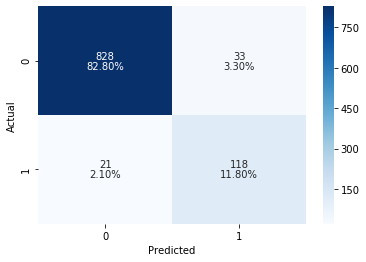

In [92]:
cm(y_test, testpredim)

In [93]:
cost_benefit(y_test, testpredim)

64180

Confusion Matrix train: 


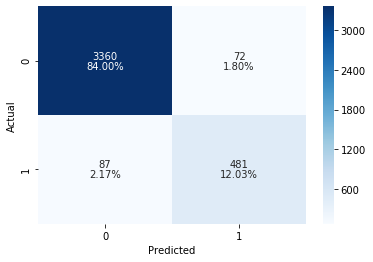

In [94]:
cm(y_train, trainpredim, t='train')

Checking FN results

In [95]:
indicesim = []
for i, true, pred in zip(y_test.index, y_test.values, testpredim):
    if pred == 0 and true == 1:
        indicesim.append(i)

In [96]:
fn_probsim = rf4.predict_proba(X_testim.loc[indicesim])[:, 1]
print(sorted(fn_probsim))

[0.040811051257037934, 0.06645022480400381, 0.07837104804454469, 0.07848569174319633, 0.0850912584053908, 0.0852451224738491, 0.08925936315887763, 0.09318264251076513, 0.10058186374296502, 0.10692409562285574, 0.11732142043114736, 0.13081100087402253, 0.1407653711231538, 0.166616438934751, 0.1672072312155645, 0.19865206514707587, 0.22255526226787528, 0.23929057260378553, 0.46263544491867853, 0.47775448122396935, 0.4985701579445848]


adjusting probs

In [97]:
probsim = []
for a in rf4.predict_proba(X_testim):
    if a[1] >=.45:
        probsim.append(1)
    else:
        probsim.append(0)

checking results again

Confusion Matrix test: 


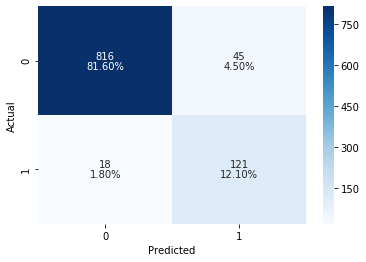

In [98]:
cm(y_test, probsim)

In [99]:
cost_benefit(y_test, probsim)

65320

In [100]:
probsimtr = []
for a in rf4.predict_proba(X_trainim):
    if a[1] >=.45:
        probsimtr.append(1)
    else:
        probsimtr.append(0)

Confusion Matrix train: 


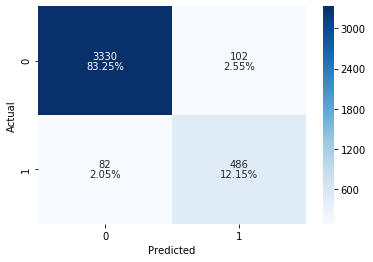

In [101]:
cm(y_train, probsimtr, t = 'train')

Trying with bagging to see if it helps

In [102]:
bagregim = BaggingClassifier(base_estimator=rf4, n_jobs=-1, n_estimators=50)

In [103]:
bagregim.fit(smoted_xim, smoted_yim)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [104]:
train_predbim = bagregim.predict(X_trainim)
test_predbim = bagregim.predict(X_testim)

results 

Confusion Matrix test: 


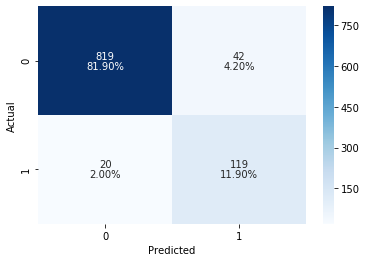

In [105]:
cm(y_test, test_predbim)

In [106]:
cost_benefit(y_test, test_predbim)

62060

Confusion Matrix train: 


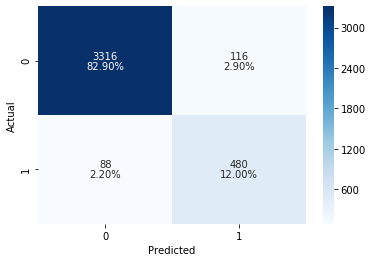

In [107]:
cm(y_train, train_predbim, t='train')

Checking FN results

In [108]:
indicesbim = []
for i, true, pred in zip(y_test.index, y_test.values, test_predbim):
    if pred == 0 and true == 1:
        indicesbim.append(i)

In [109]:
fn_probsbim = bagregim.predict_proba(X_testim.loc[indicesbim])[:, 1]
print(sorted(fn_probsbim))

[0.04119861102433165, 0.07930231651615305, 0.07947942563753997, 0.08315030115879032, 0.08363993575605727, 0.08522841989164374, 0.08763655627557579, 0.0956602839206364, 0.10141510673861777, 0.1140442277223001, 0.13316789304609766, 0.13886796851166633, 0.1461199803997074, 0.17197746880898201, 0.17392825504139922, 0.18638135464040118, 0.24441723292624293, 0.2688646331996811, 0.46894462090909017, 0.4812553497633739]


Adjusting probs

In [110]:
probsim = []
for a in bagregim.predict_proba(X_testim):
    if a[1] >=.44:
        probsim.append(1)
    else:
        probsim.append(0)

Confusion Matrix test: 


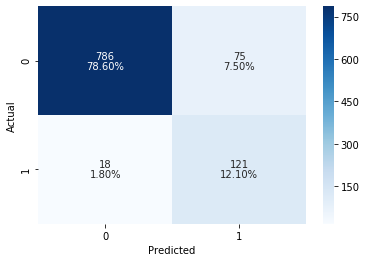

In [111]:
cm(y_test, probsim)

In [112]:
cost_benefit(y_test, probsim)

50320

In [113]:
probsimtr = []
for a in bagregim.predict_proba(X_trainim):
    if a[1] >=.41:
        probsimtr.append(1)
    else:
        probsimtr.append(0)

Confusion Matrix train: 


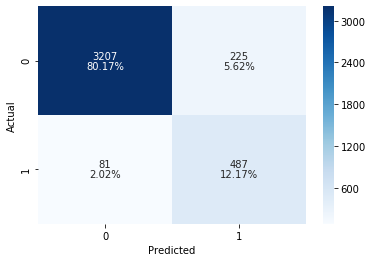

In [114]:
cm(y_train, probsimtr, t = 'train')

Our cost benefit did go down, however it is about where our average was from cross validation.  
Let's see what we can get if we work on this more to improve our interpretability

In [115]:
rf4.feature_importances_

array([0.01505128, 0.04862078, 0.19550799, 0.05590812, 0.02329943,
       0.13911182, 0.14157147, 0.04233246, 0.03604937, 0.01669822,
       0.0176632 , 0.01882068, 0.04842309, 0.0172443 , 0.18369776])

In [116]:
importdf2 = pd.DataFrame(rf4.feature_importances_)
importdf2['columns'] = X_trainim.columns
importdf2.sort_values(by=[0], ascending=False)

,0,columns
2,0.195508,international_plan
14,0.183698,number_customer_service_calls
6,0.141571,total_day_charge
5,0.139112,total_day_minutes
3,0.055908,voice_mail_plan
1,0.048621,area_code
12,0.048423,total_intl_calls
7,0.042332,total_eve_minutes
8,0.036049,total_eve_charge
4,0.023299,number_vmail_messages


Drop charge and call columns, then combine the charge columns into one

In [117]:
X_trainim = X_train.drop(['total_day_charge', 'total_eve_charge', 'total_intl_charge', 'total_night_charge', 'total_night_calls', 'total_intl_calls', 'total_eve_calls', 'total_day_calls'], axis=1)
X_testim = X_test.drop(['total_day_charge', 'total_eve_charge', 'total_intl_charge', 'total_night_charge', 'total_night_calls', 'total_intl_calls', 'total_eve_calls', 'total_day_calls'], axis=1)

Also drop low value columns, this was after iterating through the above and seeing that they are still very low compared to the other columns

In [118]:
X_trainim = X_trainim.drop(['state', 'account_length', 'area_code'], axis = 1)
X_testim = X_testim.drop(['state', 'account_length', 'area_code'], axis = 1)

Combining the charge columns

In [119]:
X_trainim['combined_charges'] = X_train['total_day_charge'] + X_train['total_eve_charge'] + X_train['total_intl_charge'] + X_train['total_night_charge']
X_testim['combined_charges'] = X_test['total_day_charge'] + X_test['total_eve_charge'] + X_test['total_intl_charge'] + X_test['total_night_charge']

Combining the minutes columns

In [120]:
X_trainim['total_min'] = X_train['total_day_minutes'] + X_train['total_eve_minutes'] + X_train['total_intl_minutes'] + X_train['total_night_minutes']
X_testim['total_min'] = X_test['total_day_minutes'] + X_test['total_eve_minutes'] + X_test['total_intl_minutes'] + X_test['total_night_minutes']

Droppping the indivdual minutes columns

In [121]:
X_trainim = X_trainim.drop(['total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'total_night_minutes'], axis = 1)
X_testim = X_testim.drop(['total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'total_night_minutes'], axis = 1)

Dropped due to the extremely high correlation between minutes and charges, also dropped number_vmail_messages due to high correlation with voice_mail_plan

In [122]:
X_trainim = X_trainim.drop(['total_min', 'number_vmail_messages'], axis = 1)
X_testim = X_testim.drop(['total_min', 'number_vmail_messages'], axis = 1)

In [123]:
smoted_xim, smoted_yim = sm.fit_sample(X_trainim, y_train)

In [124]:
clfim = RandomForestClassifier()
param_gridim = {
    "n_estimators": [10,50,100],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_leaf": [8, 10, 12, 14],
    "min_impurity_decrease": [.0001, .001, .01, .1]
}
gs_treeim = GridSearchCV(clfim, param_gridim, cv=5, scoring='recall',  n_jobs=-1, verbose=2)
gs_treeim.fit(smoted_xim, smoted_yim)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1613 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_leaf': [8, 10, 12, 14], 'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [125]:
rf_gsim = pd.DataFrame(gs_treeim.cv_results_)
rf_gsim.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.030995,0.003100,0.003807,0.000742,gini,1,0.0001,8,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.750874,0.091967,257,0.706011,0.914754,0.703933,0.701020,0.701748,0.745493,0.084649
1,0.175597,0.007918,0.014801,0.004622,gini,1,0.0001,8,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.791375,0.096886,245,0.927869,0.915483,0.703205,0.700291,0.702112,0.789792,0.107758
2,0.411600,0.017387,0.024801,0.000749,gini,1,0.0001,8,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.837704,0.109462,224,0.708561,0.914754,0.918063,0.701020,0.916606,0.831801,0.103736
3,0.039601,0.002871,0.005410,0.002817,gini,1,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.706294,0.024237,282,0.716576,0.701275,0.701020,0.700291,0.701020,0.704036,0.006278
4,0.202798,0.016362,0.014600,0.002244,gini,1,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.795163,0.105933,242,0.708925,0.701275,0.918427,0.700291,0.916970,0.789178,0.104980


In [126]:
rf_gsim.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
144,0.065798,0.002039,0.005002,0.000633,gini,10,0.0001,8,10,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",...,0.927739,0.047484,1,0.951184,0.930783,0.933358,0.932629,0.935907,0.936772,0.007391
353,0.771796,0.014275,0.030401,0.000489,entropy,10,0.001,10,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.927156,0.041756,2,0.952277,0.929326,0.929352,0.932265,0.934086,0.935461,0.008600
350,0.774398,0.009769,0.031601,0.002800,entropy,10,0.001,8,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.925991,0.043985,3,0.955920,0.931148,0.927531,0.934086,0.938820,0.937501,0.009924
349,0.389199,0.008748,0.016600,0.000800,entropy,10,0.001,8,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.925699,0.043904,4,0.959199,0.929690,0.931173,0.933722,0.937728,0.938302,0.010798
337,0.445000,0.028214,0.019200,0.001939,entropy,10,0.0001,8,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.925408,0.051727,5,0.955191,0.930419,0.933358,0.932629,0.941369,0.938593,0.009088


In [127]:
gs_treeim.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'min_samples_leaf': 8,
 'n_estimators': 10}

In this project I prefer more then 10 estimators so I went with the params that had 50

In [128]:
rf5 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=10, min_impurity_decrease=.001, min_samples_leaf=8)
rf5.fit(smoted_xim, smoted_yim)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [129]:
trainpredim = rf5.predict(X_trainim)
testpredim = rf5.predict(X_testim)

Confusion Matrix test: 


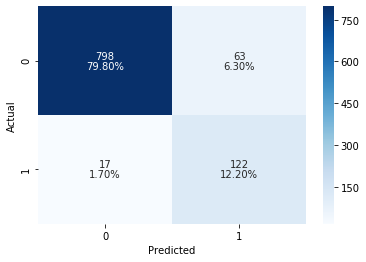

In [130]:
cm(y_test, testpredim)

In [131]:
cost_benefit(y_test, testpredim)

58700

Confusion Matrix train: 


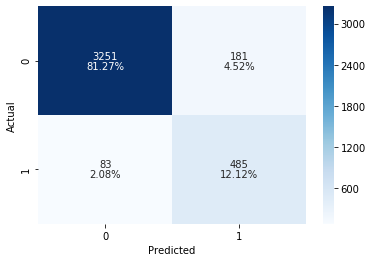

In [132]:
cm(y_train, trainpredim, t='train')

In [133]:
indicesim = []
for i, true, pred in zip(y_test.index, y_test.values, testpredim):
    if pred == 0 and true == 1:
        indicesim.append(i)

In [134]:
fn_probsim = rf5.predict_proba(X_testim.loc[indicesim])[:, 1]
print(sorted(fn_probsim))

[0.02255510710917213, 0.025734032838660128, 0.028166689339062415, 0.033074724824409346, 0.03616554097314334, 0.03676720673660813, 0.04603461225642884, 0.04625781474203349, 0.04625781474203349, 0.05672670770364494, 0.05993500856999014, 0.06547094386474593, 0.07647842989609792, 0.09721415524989144, 0.09873085879405956, 0.10925469439593372, 0.13548337676445482]


In [135]:
probsim = []
for a in rf5.predict_proba(X_testim):
    if a[1] >=.4:
        probsim.append(1)
    else:
        probsim.append(0)

Confusion Matrix test: 


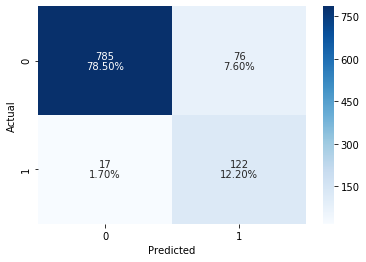

In [136]:
cm(y_test, probsim)

In [137]:
cost_benefit(y_test, probsim)

52200

In [138]:
probsimtr = []
for a in rf5.predict_proba(X_trainim):
    if a[1] >=.4:
        probsimtr.append(1)
    else:
        probsimtr.append(0)

Confusion Matrix train: 


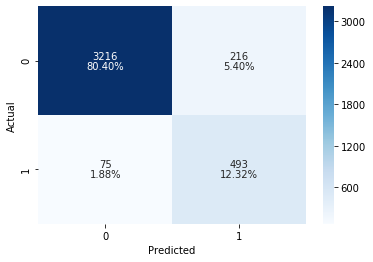

In [139]:
cm(y_train, probsimtr, t = 'train')

In [140]:
print(classification_report(y_test, probsim))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       861
           1       0.62      0.88      0.72       139

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.80      0.89      0.83      1000
weighted avg       0.93      0.91      0.91      1000



In [141]:
print(classification_report(y_test, testpredim))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       861
           1       0.66      0.88      0.75       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.90      0.85      1000
weighted avg       0.93      0.92      0.92      1000



Checking final importance

In [142]:
importdf2 = pd.DataFrame(rf5.feature_importances_)
importdf2['columns'] = X_trainim.columns
importdf2.sort_values(by=[0], ascending=False)

,0,columns
3,0.474663,combined_charges
2,0.234082,number_customer_service_calls
0,0.204282,international_plan
1,0.086973,voice_mail_plan


In [143]:
importdf2['columns'].values

array(['international_plan', 'voice_mail_plan',
       'number_customer_service_calls', 'combined_charges'], dtype=object)

Trying with bagging

In [144]:
bagregim = BaggingClassifier(base_estimator=rf5, n_jobs=-1, n_estimators=50)

In [145]:
bagregim.fit(smoted_xim, smoted_yim)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [146]:
train_predbim = bagregim.predict(X_trainim)
test_predbim = bagregim.predict(X_testim)

Confusion Matrix test: 


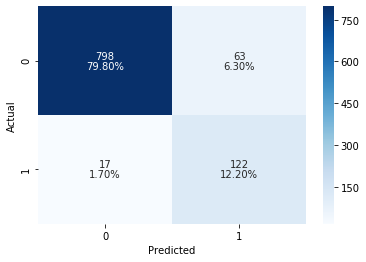

In [147]:
cm(y_test, test_predbim)

In [148]:
cost_benefit(y_test, test_predbim)

58700

Confusion Matrix train: 


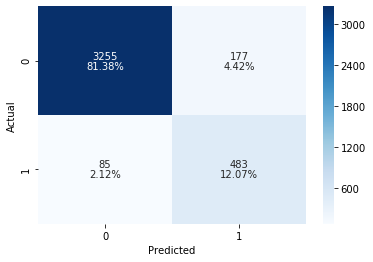

In [149]:
cm(y_train, train_predbim, t='train')

In [150]:
print(classification_report(y_test, test_predbim))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       861
           1       0.66      0.88      0.75       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.90      0.85      1000
weighted avg       0.93      0.92      0.92      1000



Checking the correlation of the features

In [151]:
test = pd.concat([X_trainim, y_train], axis=1) 

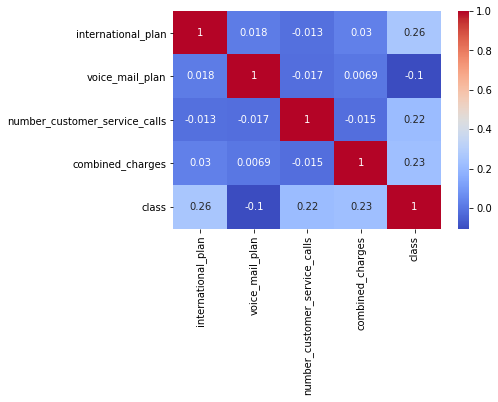

In [152]:
sns.heatmap(test.corr(), cmap='coolwarm', annot=True)

In general it seems similar to our cost benefit from the above cross validation, let's see what doing cross validation with this information will provide us

In [153]:
Xim = X.copy()

In [154]:
Xim['combined_charges'] = Xim['total_day_charge'] + Xim['total_eve_charge'] + Xim['total_intl_charge'] + Xim['total_night_charge']

In [155]:
Xim = Xim.drop(['total_day_charge', 'total_eve_charge', 'total_intl_charge', 'total_night_charge', 'total_night_calls', 'total_intl_calls', 'total_eve_calls', 'total_day_calls', 'state', 'account_length', 'area_code', 'total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'total_night_minutes', 'number_vmail_messages'], axis=1)

In [156]:
Xim.combined_charges.describe()

count    5000.000000
mean       59.492918
std        10.352006
min        22.930000
25%        52.480000
50%        59.510000
75%        66.392500
max        96.150000
Name: combined_charges, dtype: float64

Splitting with stratified kfold again

In [157]:
X_trains3 = {}
X_tests3 = {}
y_trains3 = {}
y_tests3 = {}
for i, (train_index, test_index) in enumerate(skf.split(Xim, y)):
    print(i)
    print(train_index)
    X_trains3[i] = Xim.loc[train_index]
    X_tests3[i] = Xim.loc[test_index]
    y_trains3[i] = y[train_index]
    y_tests3[i] = y[test_index]

0
[ 988  989  990 ... 4997 4998 4999]
1
[   0    1    2 ... 4997 4998 4999]
2
[   0    1    2 ... 4997 4998 4999]
3
[   0    1    2 ... 4997 4998 4999]
4
[   0    1    2 ... 3998 3999 4000]


Trying with bagging


0.8380281690140845
Confusion Matrix test: 


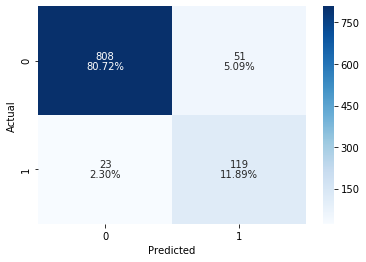

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.84      0.76       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.89      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.852112676056338
Confusion Matrix test probs: 


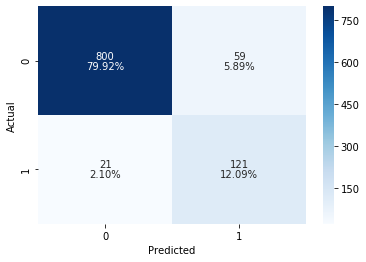

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.67      0.85      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.82      0.89      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.8169014084507042
Confusion Matrix test: 


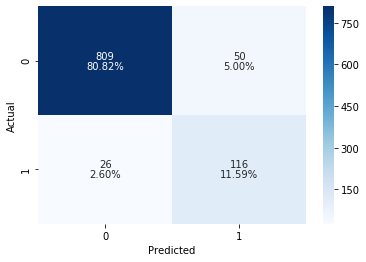

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.823943661971831
Confusion Matrix test probs: 


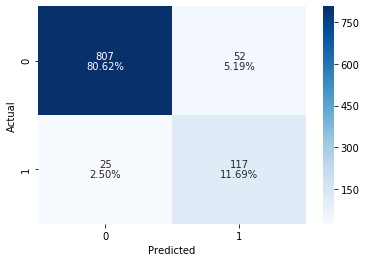

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.8014184397163121
Confusion Matrix test: 


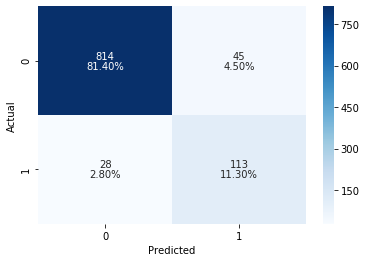

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.72      0.80      0.76       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.87      0.86      1000
weighted avg       0.93      0.93      0.93      1000


0.8368794326241135
Confusion Matrix test probs: 


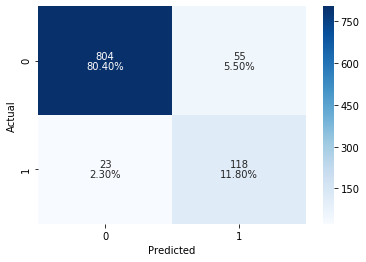

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.68      0.84      0.75       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.83      0.89      0.85      1000
weighted avg       0.93      0.92      0.93      1000


0.8865248226950354
Confusion Matrix test: 


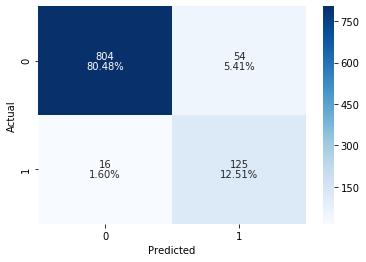

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.70      0.89      0.78       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.84      0.91      0.87       999
weighted avg       0.94      0.93      0.93       999


0.8865248226950354
Confusion Matrix test probs: 


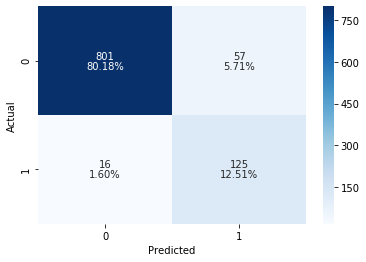

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       858
           1       0.69      0.89      0.77       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.83      0.91      0.87       999
weighted avg       0.94      0.93      0.93       999


0.8723404255319149
Confusion Matrix test: 


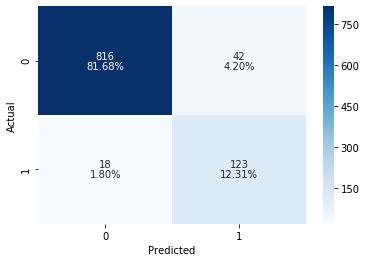

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.75      0.87      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.95      0.94      0.94       999


0.8794326241134752
Confusion Matrix test probs: 


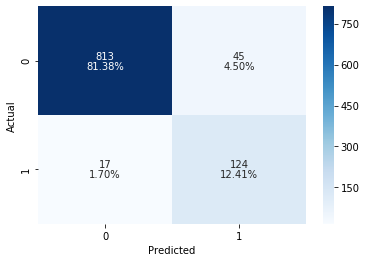

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.73      0.88      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8603239626004566 0.8430426530816103 55880.0 0.8652753369398667 0.8557786434921587 57564.0


In [158]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    bagregim.fit(smoted_x, smoted_y)
    trainpred = bagregim.predict(X_trains3[i])
    testpred = bagregim.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in bagregim.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in bagregim.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

and without bagging


0.8169014084507042
Confusion Matrix test: 


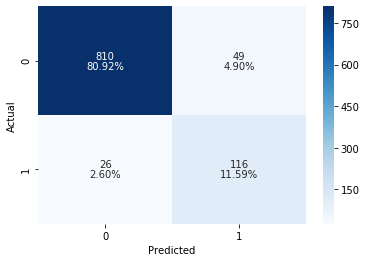

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.82      0.76       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.88      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.8661971830985915
Confusion Matrix test probs: 


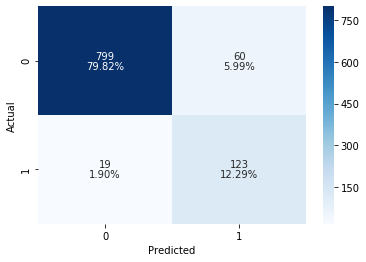

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       859
           1       0.67      0.87      0.76       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.82      0.90      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.823943661971831
Confusion Matrix test: 


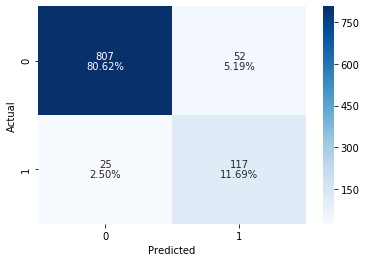

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.8450704225352113
Confusion Matrix test probs: 


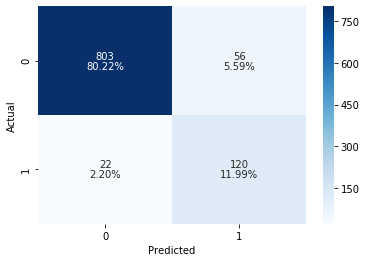

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.68      0.85      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.89      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.7872340425531915
Confusion Matrix test: 


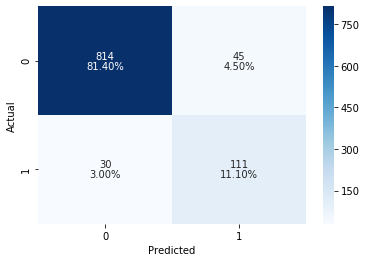

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       859
           1       0.71      0.79      0.75       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.87      0.85      1000
weighted avg       0.93      0.93      0.93      1000


0.8226950354609929
Confusion Matrix test probs: 


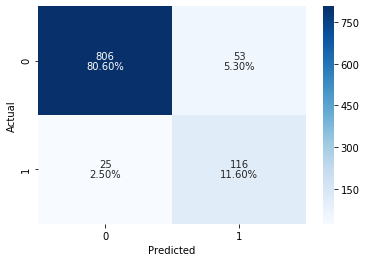

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.83      0.88      0.85      1000
weighted avg       0.93      0.92      0.92      1000


0.8865248226950354
Confusion Matrix test: 


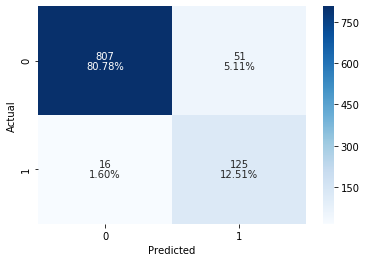

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.71      0.89      0.79       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.85      0.91      0.87       999
weighted avg       0.94      0.93      0.94       999


0.8865248226950354
Confusion Matrix test probs: 


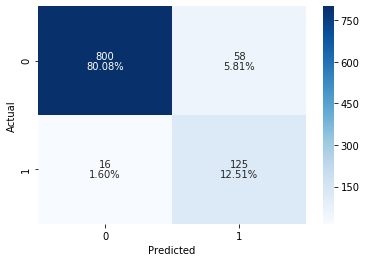

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       858
           1       0.68      0.89      0.77       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.83      0.91      0.86       999
weighted avg       0.94      0.93      0.93       999


0.8723404255319149
Confusion Matrix test: 


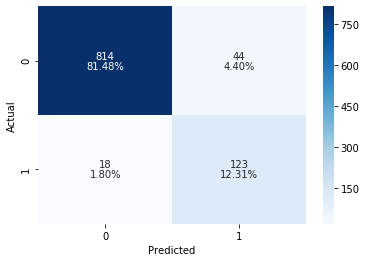

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.74      0.87      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999


0.8723404255319149
Confusion Matrix test probs: 


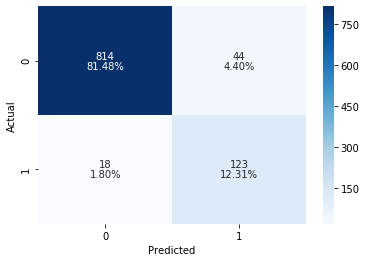

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.74      0.87      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8596191250508145 0.8373888722405354 54076.0 0.8652784639919947 0.8585655778643492 58216.0


In [159]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    rf5.fit(smoted_x, smoted_y)
    trainpred = rf5.predict(X_trains3[i])
    testpred = rf5.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in rf5.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in rf5.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

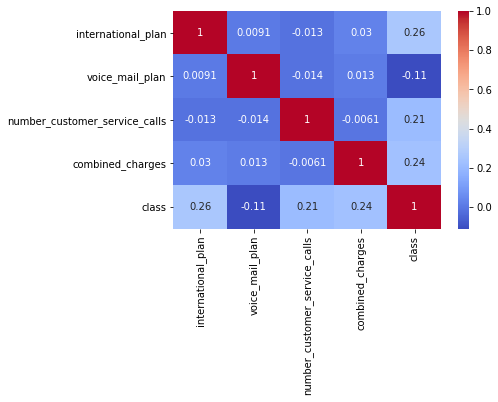

In [160]:
imdf = pd.concat([Xim, y], axis=1)
sns.heatmap(imdf.corr(), cmap='coolwarm', annot=True)

The cost/benefit of the cross validation is very similar without bagging and is better then the cost/benefit from the cross validation that was done with all the features

[Return to contents](#Table-of-Contents)

## XgBoost

Seeing if we can get better results with XgBoost

In [161]:
clf = xgb.XGBClassifier()

In [162]:
param_grid = {
    "learning_rate": [0.1, .01, .2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [8, 10, 12],
    'subsample': [.6, 0.7, .8],
    'n_estimators': [5, 30, 100, 250],
}

In [163]:
grid_xb = GridSearchCV(clf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_xb.fit(X_train_smoted, y_train_smoted)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.2], 'max_depth': [4, 6, 8], 'min_child_weight': [8, 10, 12], 'subsample': [0.6, 0.7, 0.8], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [164]:
xb_gs = pd.DataFrame(grid_xb.cv_results_)
xb_gs.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.078594,0.002575,0.003800,0.000399,0.1,4,8,5,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.810023,0.053119,298,0.822951,0.816029,0.817189,0.808813,0.807356,0.814468,0.005733
1,0.079998,0.002760,0.003801,0.001721,0.1,4,8,5,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.809149,0.055875,301,0.820765,0.829872,0.805899,0.812090,0.805535,0.814833,0.009329
2,0.081397,0.007058,0.003400,0.000490,0.1,4,8,5,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.804196,0.053059,306,0.818579,0.808743,0.806992,0.812090,0.809905,0.811262,0.004016
3,0.379598,0.010230,0.004001,0.000001,0.1,4,8,30,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.891608,0.068542,184,0.934791,0.903825,0.897305,0.905681,0.913328,0.910986,0.012952
4,0.385599,0.011792,0.004201,0.000400,0.1,4,8,30,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.889569,0.070669,190,0.926776,0.899089,0.902768,0.898398,0.909687,0.907343,0.010509


In [165]:
xb_gs.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
80,2.132398,0.085887,0.014601,0.001021,0.1,8,8,100,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.942308,0.104429,1,0.995993,0.974863,0.975601,0.974873,0.973416,0.978949,0.008551
293,0.654997,0.011813,0.005601,0.000490,0.2,8,8,30,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.939685,0.093681,2,0.993443,0.966485,0.967225,0.965768,0.966861,0.971956,0.010754
79,2.019398,0.070389,0.014401,0.000800,0.1,8,8,100,0.7,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.937646,0.109385,3,0.994900,0.973042,0.973416,0.971231,0.972688,0.977055,0.008953
292,0.638599,0.010557,0.005800,0.000749,0.2,8,8,30,0.7,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.937354,0.098350,4,0.991257,0.963934,0.966497,0.965768,0.964676,0.970426,0.010452
44,1.731596,0.020106,0.012800,0.000400,0.1,6,8,100,0.8,"{'learning_rate': 0.1, 'max_depth': 6, 'min_ch...",...,0.936189,0.112341,5,0.994536,0.969399,0.972323,0.967589,0.968682,0.974506,0.010137


In [166]:
xb_gs['test_train_diff'] = xb_gs['mean_train_score'] - xb_gs['mean_test_score']

In [167]:
xb_gs['wighted_test'] = xb_gs['mean_test_score'] - xb_gs['test_train_diff']

In [168]:
xb_gs.sort_values(by=['wighted_test'], ascending=False).drop(['split0_train_score', 'split1_train_score'], axis=1).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,test_train_diff,wighted_test
293,0.654997,0.011813,0.005601,0.000490,0.2,8,8,30,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.939685,0.093681,2,0.967225,0.965768,0.966861,0.971956,0.010754,0.032271,0.907414
89,0.667199,0.011303,0.005401,0.000491,0.1,8,10,30,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.925991,0.058857,30,0.938456,0.938820,0.942098,0.946097,0.012267,0.020106,0.905884
80,2.132398,0.085887,0.014601,0.001021,0.1,8,8,100,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.942308,0.104429,1,0.975601,0.974873,0.973416,0.978949,0.008551,0.036641,0.905666
292,0.638599,0.010557,0.005800,0.000749,0.2,8,8,30,0.7,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.937354,0.098350,4,0.966497,0.965768,0.964676,0.970426,0.010452,0.033072,0.904282
77,0.692397,0.011253,0.005401,0.000488,0.1,8,8,30,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.927156,0.056466,25,0.941369,0.943554,0.944283,0.950031,0.014643,0.022874,0.904282


In [169]:
grid_xb.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 8,
 'n_estimators': 100,
 'subsample': 0.8}

In [170]:
xb2 = xgb.XGBClassifier(learning_rate=.1, max_depth=6, min_child_weight=8, n_estimators=30, subsample=.8)

In [171]:
xsmote = pd.DataFrame(X_train_smoted, columns=X.columns)

In [172]:
xb2.fit(xsmote, y_train_smoted)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=30, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.8, verbosity=1)

In [173]:
train_pred3 = xb2.predict(X_train)
train_pred_smoted3 = xb2.predict(xsmote)
test_pred3 = xb2.predict(X_test)

Confusion Matrix test: 


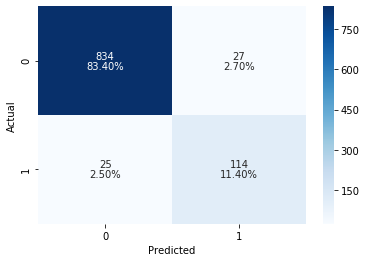

In [174]:
cm(y_test, test_pred3)

Confusion Matrix train: 


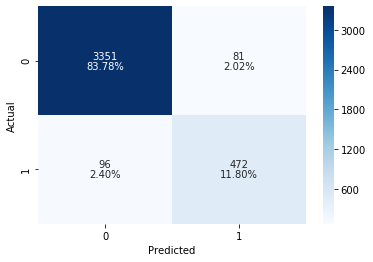

In [175]:
cm(y_train, train_pred3, t='train')

Confusion Matrix train_smoted: 


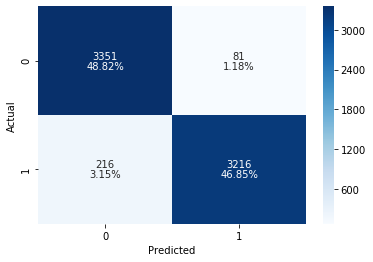

In [176]:
cm(y_train_smoted, train_pred_smoted3, t='train_smoted')

In [177]:
print(classification_report(y_test, test_pred3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       861
           1       0.81      0.82      0.81       139

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.95      0.95      0.95      1000



In [178]:
print(classification_report(y_train, train_pred3))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3432
           1       0.85      0.83      0.84       568

   micro avg       0.96      0.96      0.96      4000
   macro avg       0.91      0.90      0.91      4000
weighted avg       0.96      0.96      0.96      4000



In [179]:
xb2.feature_importances_

array([0.00783218, 0.00917735, 0.06690163, 0.23304577, 0.07592934,
       0.00425411, 0.09508295, 0.0100784 , 0.06153402, 0.03964575,
       0.01057109, 0.08901095, 0.01801988, 0.01020691, 0.02931472,
       0.04087351, 0.04260686, 0.03173709, 0.1241775 ], dtype=float32)

In [180]:
importxb = pd.DataFrame(xb2.feature_importances_)
importxb['columns'] = X_train.columns
importxb.sort_values(by=[0], ascending=False)

,0,columns
3,0.233046,international_plan
18,0.124178,number_customer_service_calls
6,0.095083,total_day_minutes
11,0.089011,total_eve_charge
4,0.075929,voice_mail_plan
2,0.066902,area_code
8,0.061534,total_day_charge
16,0.042607,total_intl_calls
15,0.040874,total_intl_minutes
9,0.039646,total_eve_minutes


In [181]:
grid_xb2 = GridSearchCV(clf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_xb2.fit(smoted_xim, smoted_yim)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.2], 'max_depth': [4, 6, 8], 'min_child_weight': [8, 10, 12], 'subsample': [0.6, 0.7, 0.8], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [182]:
xb_gs2 = pd.DataFrame(grid_xb2.cv_results_)
xb_gs2.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.020201,0.002319,0.001999,1.438437e-06,0.1,4,8,5,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.912587,0.023108,149,0.924590,0.908561,0.912236,0.910051,0.910415,0.913171,0.005828
1,0.036602,0.014362,0.002200,3.990895e-04,0.1,4,8,5,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.912587,0.023108,149,0.924954,0.908925,0.912236,0.910051,0.910415,0.913316,0.005916
2,0.025998,0.006633,0.002000,8.449576e-07,0.1,4,8,5,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.912587,0.023108,149,0.924954,0.908925,0.912236,0.910051,0.910779,0.913389,0.005882
3,0.109599,0.002654,0.002401,4.907774e-04,0.1,4,8,30,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.910839,0.027252,174,0.924954,0.908925,0.912236,0.910415,0.910779,0.913462,0.005842
4,0.121000,0.008295,0.003201,9.822183e-04,0.1,4,8,30,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.909091,0.030691,190,0.922040,0.908925,0.912236,0.910415,0.910779,0.912879,0.004700


In [183]:
xb_gs2.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
309,2.389599,0.026469,0.024001,0.002530,0.2,8,10,250,0.6,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.939977,0.062762,1,0.975592,0.951548,0.949745,0.948288,0.953023,0.955639,0.010104
298,1.346000,0.058691,0.027399,0.001855,0.2,8,8,250,0.7,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.939394,0.064614,2,0.977413,0.954827,0.956300,0.955936,0.957028,0.960301,0.008586
261,1.180798,0.016630,0.025801,0.000979,0.2,6,8,250,0.6,"{'learning_rate': 0.2, 'max_depth': 6, 'min_ch...",...,0.939394,0.062390,2,0.977049,0.951548,0.951202,0.949745,0.952658,0.956441,0.010346
311,1.450601,0.097496,0.027999,0.001788,0.2,8,10,250,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.939103,0.062957,4,0.976321,0.952641,0.954843,0.952294,0.954479,0.958116,0.009157
273,1.299399,0.160122,0.023801,0.000749,0.2,6,10,250,0.6,"{'learning_rate': 0.2, 'max_depth': 6, 'min_ch...",...,0.938811,0.061434,5,0.974135,0.947905,0.949017,0.948653,0.952294,0.954401,0.009981


In [184]:
xb_gs2['test_train_diff'] = xb_gs2['mean_train_score'] - xb_gs2['mean_test_score']

In [185]:
xb_gs2['weighted_test'] = xb_gs2['mean_test_score'] - xb_gs2['test_train_diff']

In [186]:
xb_gs2.sort_values(by=['weighted_test'], ascending=False).drop(['split0_train_score', 'split1_train_score'], axis=1).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,test_train_diff,weighted_test
237,0.920398,0.004454,0.020001,0.002282,0.2,4,10,250,0.6,"{'learning_rate': 0.2, 'max_depth': 4, 'min_ch...",...,0.938520,0.058935,6,0.946103,0.941369,0.950838,0.950759,0.010684,0.012239,0.926281
59,1.235801,0.033875,0.025799,0.000401,0.1,6,10,250,0.8,"{'learning_rate': 0.1, 'max_depth': 6, 'min_ch...",...,0.937937,0.060994,9,0.946832,0.941369,0.948653,0.950832,0.011008,0.012894,0.925043
309,2.389599,0.026469,0.024001,0.002530,0.2,8,10,250,0.6,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.939977,0.062762,1,0.949745,0.948288,0.953023,0.955639,0.010104,0.015663,0.924314
258,0.491400,0.008187,0.010601,0.000490,0.2,6,8,100,0.6,"{'learning_rate': 0.2, 'max_depth': 6, 'min_ch...",...,0.936480,0.059016,27,0.945011,0.943190,0.946468,0.949010,0.009961,0.012530,0.923950
273,1.299399,0.160122,0.023801,0.000749,0.2,6,10,250,0.6,"{'learning_rate': 0.2, 'max_depth': 6, 'min_ch...",...,0.938811,0.061434,5,0.949017,0.948653,0.952294,0.954401,0.009981,0.015590,0.923222


In [187]:
grid_xb2.best_params_

{'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 10,
 'n_estimators': 250,
 'subsample': 0.6}

In [188]:
xb2 = xgb.XGBClassifier(learning_rate=.1, max_depth=6, min_child_weight=12, n_estimators=250, subsample=.6)

In [189]:
xsmote = pd.DataFrame(smoted_xim, columns=X_trainim.columns)

In [190]:
xb2.fit(xsmote, smoted_yim)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=12, missing=None,
       n_estimators=250, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.6, verbosity=1)

In [191]:
train_pred3 = xb2.predict(X_trainim)
train_pred_smoted3 = xb2.predict(xsmote)
test_pred3 = xb2.predict(X_testim)

Confusion Matrix test: 


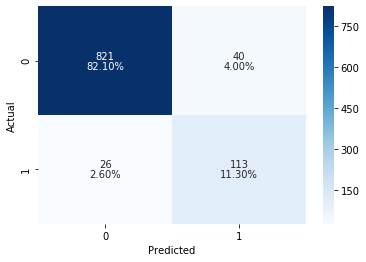

In [192]:
cm(y_test, test_pred3)

Confusion Matrix train: 


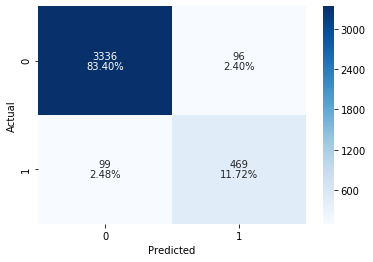

In [193]:
cm(y_train, train_pred3, t='train')

Confusion Matrix train_smoted: 


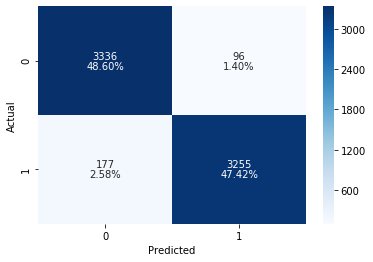

In [194]:
cm(y_train_smoted, train_pred_smoted3, t='train_smoted')

In [195]:
print(classification_report(y_test, test_pred3))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       861
           1       0.74      0.81      0.77       139

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.85      0.88      0.87      1000
weighted avg       0.94      0.93      0.94      1000



In [196]:
print(classification_report(y_train, train_pred3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3432
           1       0.83      0.83      0.83       568

   micro avg       0.95      0.95      0.95      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.95      0.95      0.95      4000




0.7746478873239436
Confusion Matrix test: 


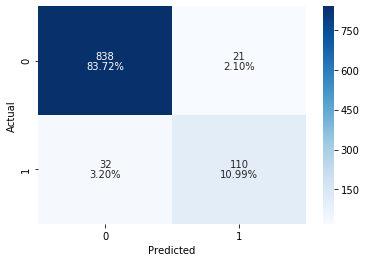

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       859
           1       0.84      0.77      0.81       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.90      0.88      0.89      1001
weighted avg       0.95      0.95      0.95      1001


0.8028169014084507
Confusion Matrix test probs: 


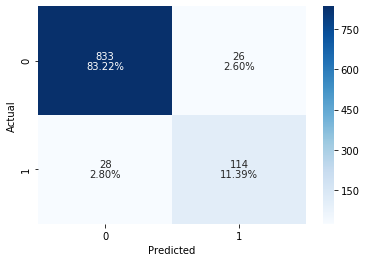

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       859
           1       0.81      0.80      0.81       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.89      0.89      0.89      1001
weighted avg       0.95      0.95      0.95      1001


0.795774647887324
Confusion Matrix test: 


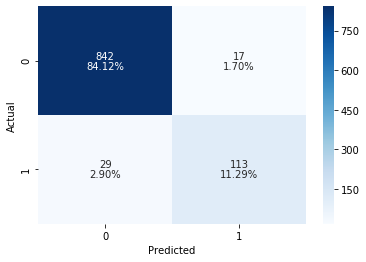

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       859
           1       0.87      0.80      0.83       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.92      0.89      0.90      1001
weighted avg       0.95      0.95      0.95      1001


0.795774647887324
Confusion Matrix test probs: 


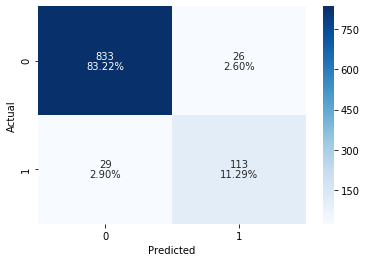

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       859
           1       0.81      0.80      0.80       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.89      0.88      0.89      1001
weighted avg       0.94      0.95      0.94      1001


0.723404255319149
Confusion Matrix test: 


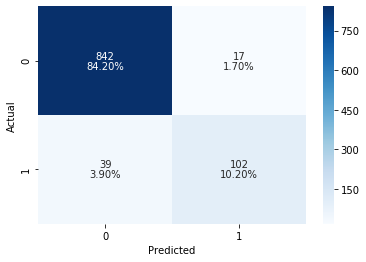

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       859
           1       0.86      0.72      0.78       141

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.91      0.85      0.88      1000
weighted avg       0.94      0.94      0.94      1000


0.7588652482269503
Confusion Matrix test probs: 


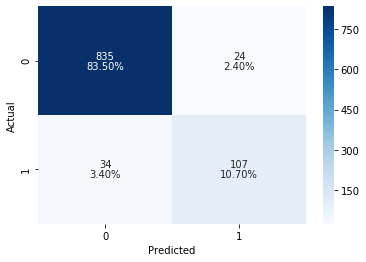

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       859
           1       0.82      0.76      0.79       141

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.89      0.87      0.88      1000
weighted avg       0.94      0.94      0.94      1000


0.7446808510638298
Confusion Matrix test: 


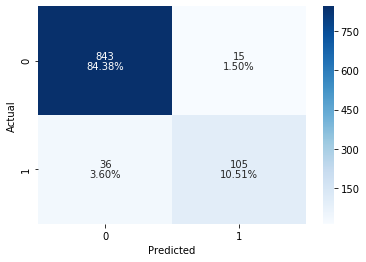

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       858
           1       0.88      0.74      0.80       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.92      0.86      0.89       999
weighted avg       0.95      0.95      0.95       999


0.7872340425531915
Confusion Matrix test probs: 


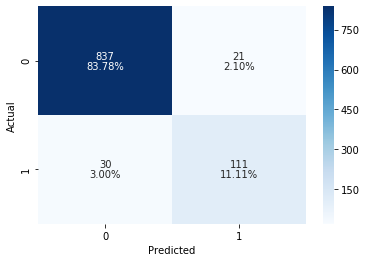

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       858
           1       0.84      0.79      0.81       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.90      0.88      0.89       999
weighted avg       0.95      0.95      0.95       999


0.8156028368794326
Confusion Matrix test: 


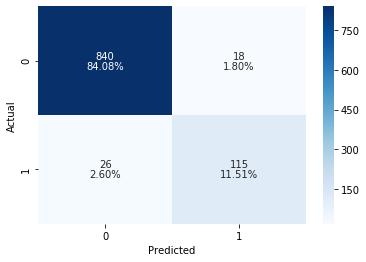

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       858
           1       0.86      0.82      0.84       141

   micro avg       0.96      0.96      0.96       999
   macro avg       0.92      0.90      0.91       999
weighted avg       0.96      0.96      0.96       999


0.8226950354609929
Confusion Matrix test probs: 


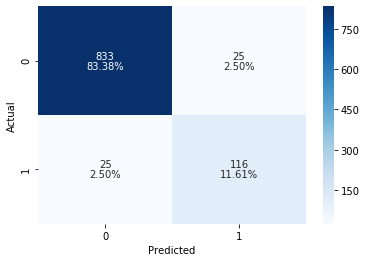

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       858
           1       0.82      0.82      0.82       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.95      0.95      0.95       999

0.8712880327715062 0.7708220956947358 47004.0 0.8840176365740018 0.7934771751073819 51220.0


In [197]:
scores3 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains2[i], y_trains2[i])
    xsmote = pd.DataFrame(smoted_x, columns=X.columns)
    xb2.fit(xsmote, smoted_y)
    trainpred = xb2.predict(X_trains2[i])
    testpred = xb2.predict(X_tests2[i])
    train += recall_score(y_trains2[i], trainpred)
    test += recall_score(y_tests2[i], testpred)
    probs = []
    for a in xb2.predict_proba(X_tests2[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in xb2.predict_proba(X_trains2[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests2[i], testpred)
    probcb += cost_benefit(y_tests2[i], probs)
    testprobs += recall_score(y_tests2[i], probs)
    trainprobs += recall_score(y_trains2[i], probs2)
    scores2.append((i, recall_score(y_trains2[i], trainpred), recall_score(y_tests2[i], testpred), recall_score(y_trains2[i], probs2), recall_score(y_tests2[i], probs)))
    print(f'\n{recall_score(y_tests2[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests2[i], testpred))
    print(f'\n{recall_score(y_tests2[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests2[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)


0.7535211267605634
Confusion Matrix test: 


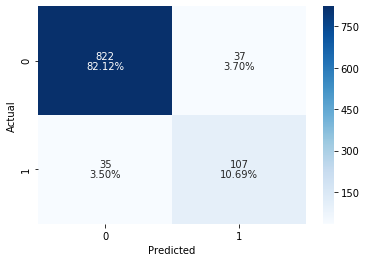

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       859
           1       0.74      0.75      0.75       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.85      0.86      0.85      1001
weighted avg       0.93      0.93      0.93      1001


0.7605633802816901
Confusion Matrix test probs: 


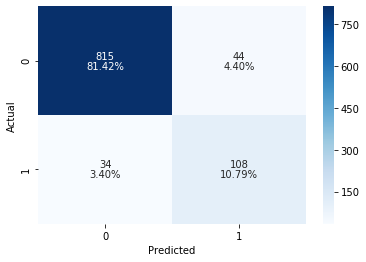

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       859
           1       0.71      0.76      0.73       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.84      0.85      0.84      1001
weighted avg       0.92      0.92      0.92      1001


0.7746478873239436
Confusion Matrix test: 


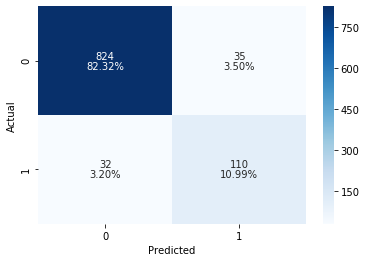

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       859
           1       0.76      0.77      0.77       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.86      0.87      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.795774647887324
Confusion Matrix test probs: 


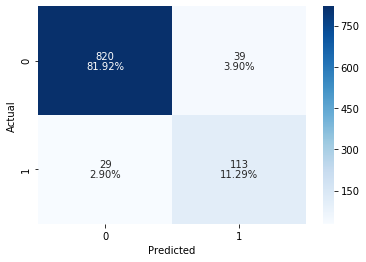

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.74      0.80      0.77       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.85      0.88      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.7446808510638298
Confusion Matrix test: 


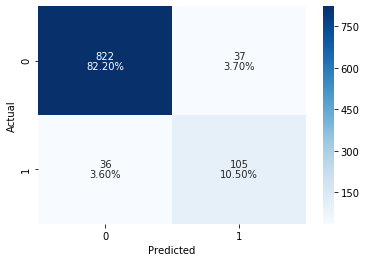

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       859
           1       0.74      0.74      0.74       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.93      0.93      0.93      1000


0.7588652482269503
Confusion Matrix test probs: 


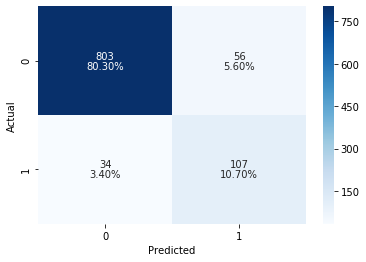

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       859
           1       0.66      0.76      0.70       141

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.81      0.85      0.83      1000
weighted avg       0.92      0.91      0.91      1000


0.8368794326241135
Confusion Matrix test: 


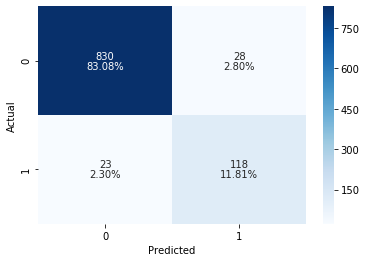

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       858
           1       0.81      0.84      0.82       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.89      0.90      0.90       999
weighted avg       0.95      0.95      0.95       999


0.851063829787234
Confusion Matrix test probs: 


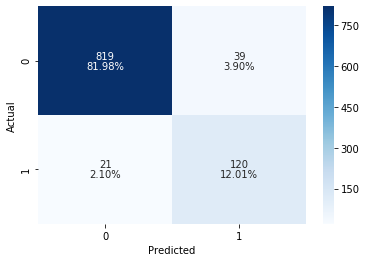

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       858
           1       0.75      0.85      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.90      0.88       999
weighted avg       0.94      0.94      0.94       999


0.7446808510638298
Confusion Matrix test: 


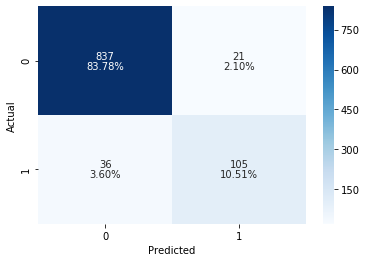

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       858
           1       0.83      0.74      0.79       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.90      0.86      0.88       999
weighted avg       0.94      0.94      0.94       999


0.7801418439716312
Confusion Matrix test probs: 


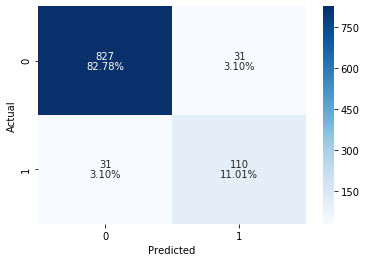

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       858
           1       0.78      0.78      0.78       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.87      0.87      0.87       999
weighted avg       0.94      0.94      0.94       999

0.8231983489164765 0.7708820297672561 40004.0 0.8504255917946152 0.7892817900309659 41092.0


In [198]:
scores4 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    xsmote = pd.DataFrame(smoted_x, columns=Xim.columns)
    xb2.fit(xsmote, smoted_y)
    trainpred = xb2.predict(X_trains3[i])
    testpred = xb2.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in xb2.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in xb2.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests3[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests3[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

The cost/benefit is much lower with XgBoost

[Return to contents](#Table-of-Contents)

## Looking further into feature importance

Trying to figure out if there are trends here that can be used for business purposes

In [199]:
Xim2 = Xim.copy()

In [200]:
Xim2['probs'] = rf5.predict_proba(Xim)[:, 1]

In [201]:
Xim2['target']= y.values

In [202]:
Xim2.columns

Index(['international_plan', 'voice_mail_plan',
       'number_customer_service_calls', 'combined_charges', 'probs', 'target'],
      dtype='object')

Checking scatter plots of each feature with the probs. Comparing it to the true results

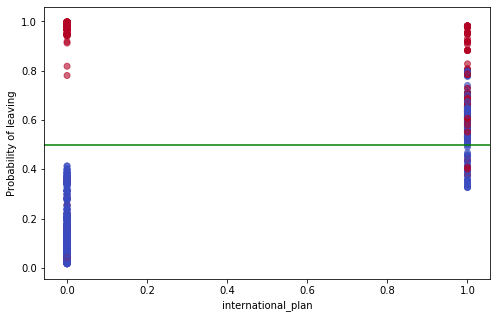

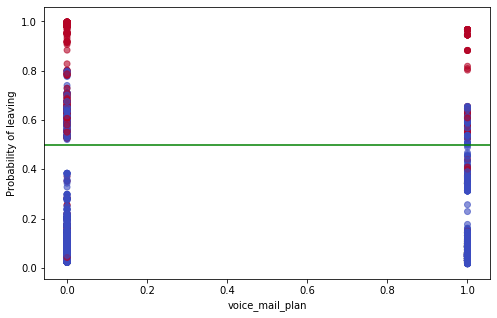

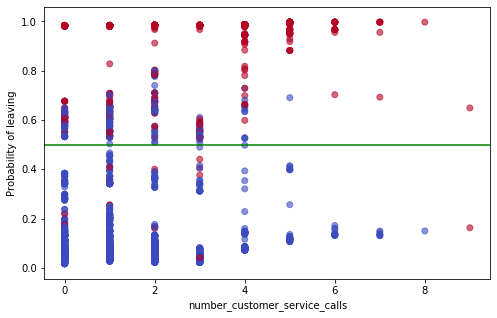

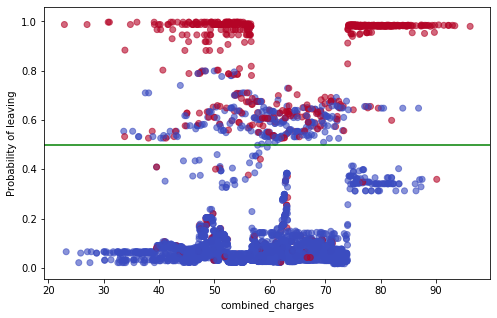

In [204]:
for col in Xim2.drop(['probs', 'target'], axis=1).columns:
    plt.figure(figsize=(8,5))
    plt.scatter(col, 'probs', data=Xim2, c='target', cmap='coolwarm', alpha=.6)
    plt.xlabel(col)
    plt.ylabel('Probability of leaving')
    plt.axhline(y=0.5, color='g', linestyle='-')
    plt.show()

Checking scatter plots of each feature with every other feature, with the true results as well

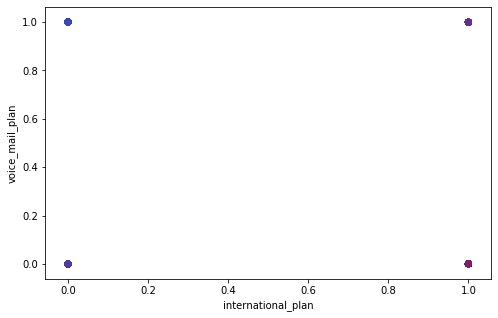

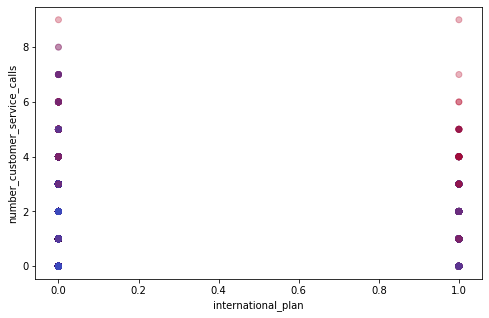

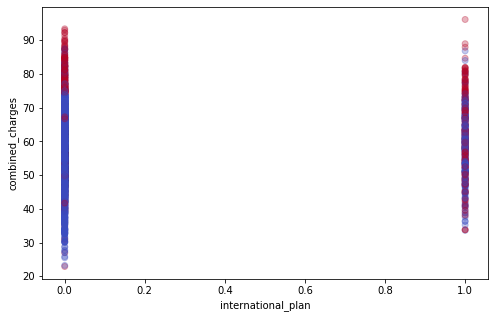

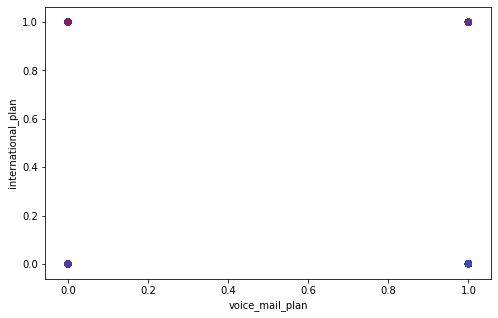

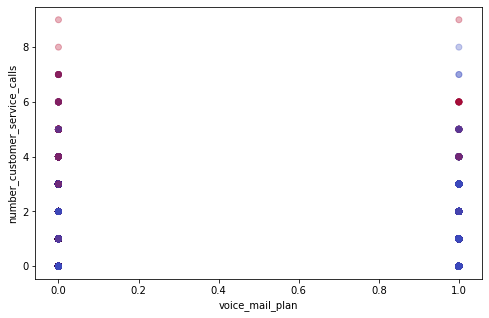

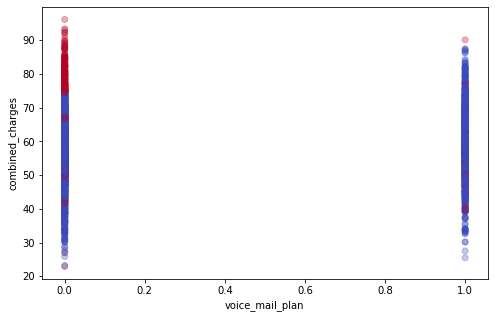

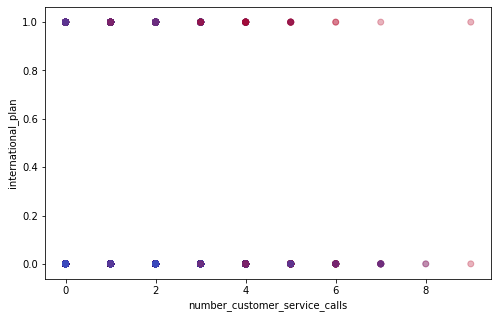

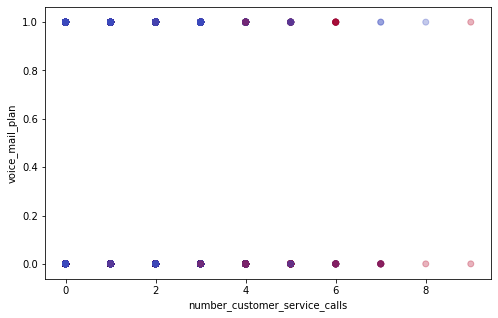

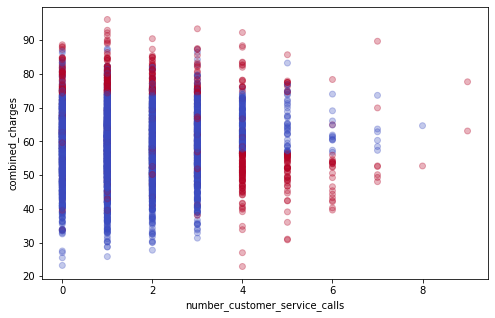

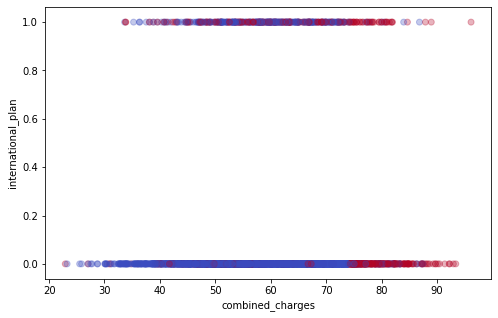

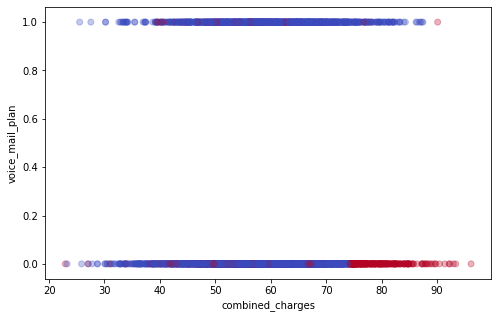

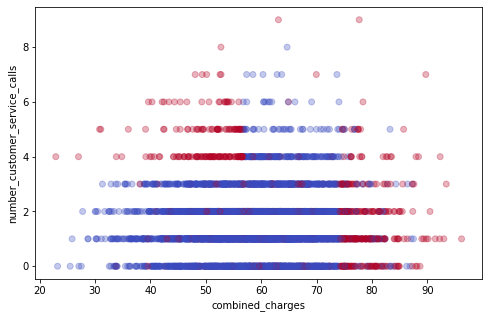

In [205]:
for col in Xim2.drop(['probs', 'target'], axis=1).columns:
    for col2 in Xim2.drop(['probs', 'target'], axis=1).columns:
        if col == col2:
            continue
        plt.figure(figsize=(8,5))
        plt.scatter(col, col2, data=Xim2, c='target', cmap='coolwarm', alpha=.3)
        plt.xlabel(col)
        plt.ylabel(col2)
        plt.show()

There seems to be a big difference with charges over 72

In [206]:
Xim2.loc[Xim2['combined_charges'] > 72].target.value_counts()

1    315
0    247
Name: target, dtype: int64

We see there are actually more customers leaving then staying with bills over 72

Checking what the cost benefit per customer staying would be if we just offered the promo to every customer with a high bill

In [207]:
(315*940 - 247*500)/315

547.936507936508

Checking combined charges over $72 with an international plan churn rate

In [208]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['international_plan'] == 1)].target.value_counts()

1    49
0    19
Name: target, dtype: int64

Checking customer service calls of customers with combined charges over $72 and leaving the service

In [209]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['target'] == 1)].number_customer_service_calls.value_counts()

1    117
2     65
0     65
3     40
4     16
5      9
9      1
7      1
6      1
Name: number_customer_service_calls, dtype: int64

Checking customer service calls of customers with combined charges over $72 and not canceling service

In [210]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['target'] == 0)].number_customer_service_calls.value_counts()

1    91
0    48
2    42
3    40
4    15
5     9
7     1
6     1
Name: number_customer_service_calls, dtype: int64

Checking churn rate charges over $72 and more then 1 or 2 customer service calls

In [211]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['number_customer_service_calls'] >= 1)].target.value_counts()

1    250
0    199
Name: target, dtype: int64

In [212]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['number_customer_service_calls'] >= 2)].target.value_counts()

1    133
0    108
Name: target, dtype: int64

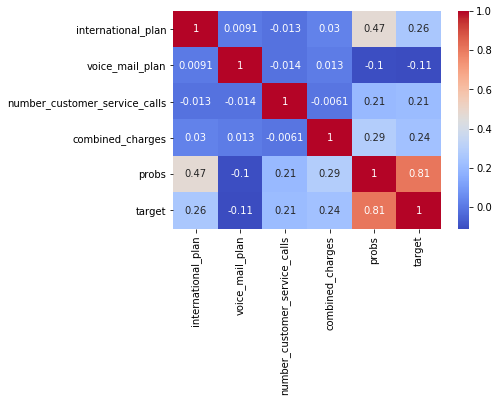

In [213]:
sns.heatmap(Xim2.corr(), cmap='coolwarm', annot=True)

In [214]:
tpred = rf5.predict(Xim)

Confusion Matrix test: 


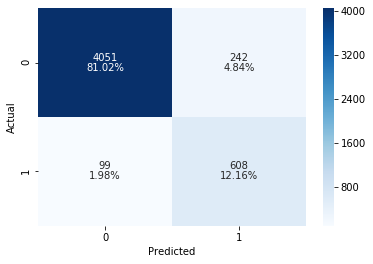

In [215]:
cm(Xim2.target.values, tpred)

In [216]:
cost_benefit(Xim2.target.values, tpred)

307960

Confusion Matrix test: 


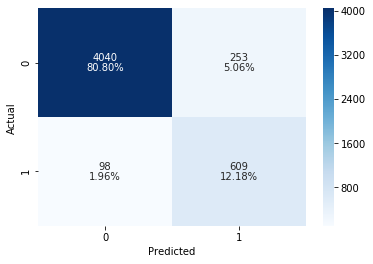

304840


In [221]:
probs = []
for a in rf5.predict_proba(Xim):
    if a[1] >=.42:
        probs.append(1)
    else:
        probs.append(0)
cm(Xim2.target.values, probs)
print(cost_benefit(Xim2.target.values, probs))

In [224]:
print(classification_report(Xim2.target.values, tpred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4293
           1       0.72      0.86      0.78       707

   micro avg       0.93      0.93      0.93      5000
   macro avg       0.85      0.90      0.87      5000
weighted avg       0.94      0.93      0.93      5000



[Return to contents](#Table-of-Contents)

## Final Model

In [229]:
rf5 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=10, min_impurity_decrease=.001, min_samples_leaf=8)
rf5.fit(smoted_xim, smoted_yim)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


0.8380281690140845
Confusion Matrix test: 


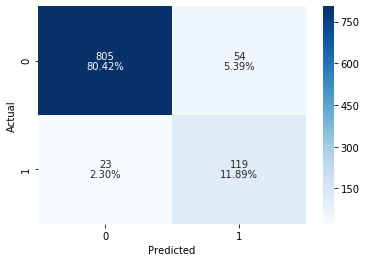

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.84      0.76       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.89      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.852112676056338
Confusion Matrix test probs: 


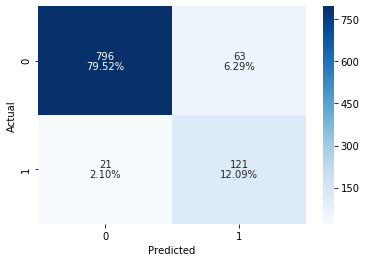

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.66      0.85      0.74       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.82      0.89      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.8169014084507042
Confusion Matrix test: 


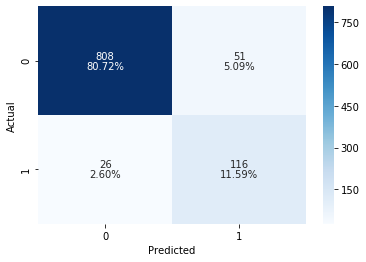

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.823943661971831
Confusion Matrix test probs: 


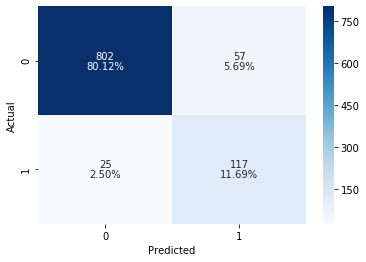

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.67      0.82      0.74       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.82      0.88      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.7943262411347518
Confusion Matrix test: 


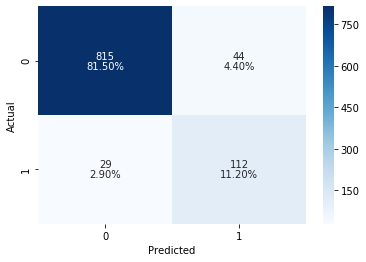

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.72      0.79      0.75       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.87      0.86      1000
weighted avg       0.93      0.93      0.93      1000


0.8368794326241135
Confusion Matrix test probs: 


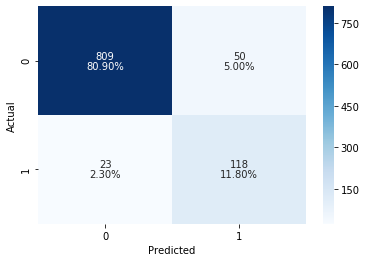

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.84      0.76       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.89      0.86      1000
weighted avg       0.93      0.93      0.93      1000


0.8794326241134752
Confusion Matrix test: 


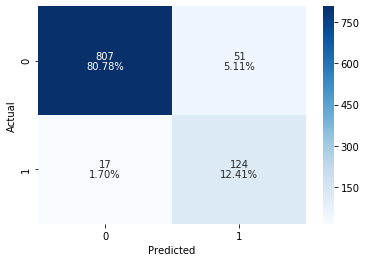

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.71      0.88      0.78       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.84      0.91      0.87       999
weighted avg       0.94      0.93      0.93       999


0.8865248226950354
Confusion Matrix test probs: 


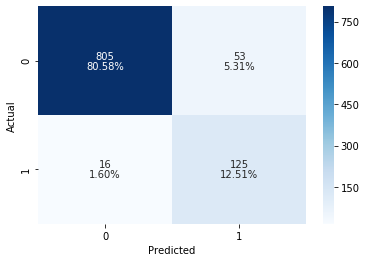

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.70      0.89      0.78       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.84      0.91      0.87       999
weighted avg       0.94      0.93      0.93       999


0.8297872340425532
Confusion Matrix test: 


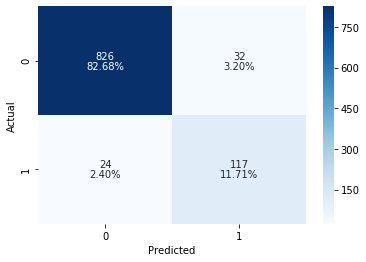

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       858
           1       0.79      0.83      0.81       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.88      0.90      0.89       999
weighted avg       0.95      0.94      0.94       999


0.8652482269503546
Confusion Matrix test probs: 


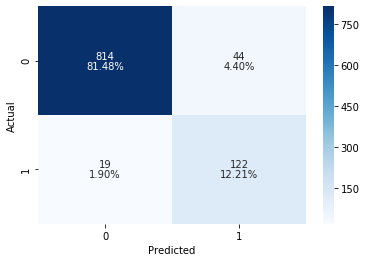

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.73      0.87      0.79       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8567935207479909 0.8316951353511138 53072.0 0.8649238562806841 0.8529417640595345 56712.0


In [230]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    rf5.fit(smoted_x, smoted_y)
    trainpred = rf5.predict(X_trains3[i])
    testpred = rf5.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in rf5.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in rf5.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

[Return to contents](#Table-of-Contents)

## Recommendations

I would recommend a promo for customers that we predict are leaving as the cost/benefit shows that we can gain from that

[Return to contents](#Table-of-Contents)

## Further Work

Doing research to figure out the best promo amount to help retain customers

[Return to contents](#Table-of-Contents)